# An introductory note

This notebook serves as the one place where you can find out everything about bioscrape inference -- use cases, features, debugging, and development. A basic familiarity with probability distributions, Bayesian inference and Markov Chain Monte Carlo (MCMC) is assumed. To learn about the internal programming details of running an MCMC algorithm, refer to the `emcee_tutorial.ipynb`. 

# Let's start with a simple example - A linear model

Consider the linear model: y = mx + b and let's create an artificial data set for this model by adding noise to its simulation:

(this example is taken from emcee package documentation and modified to be used with bioscrape inference)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

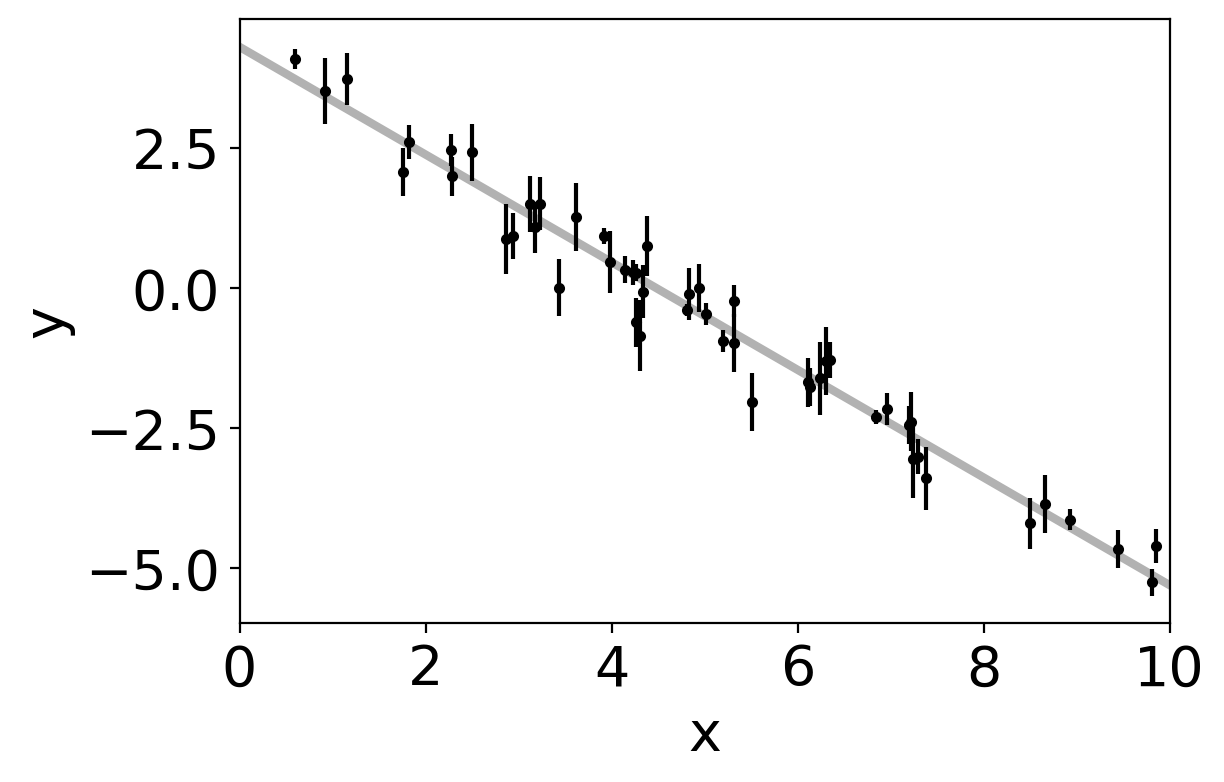

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
# f_true = 0.534
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

species = ['y']
parameters = {'m':m_true, 'b': b_true}
rule = ('assignment',{'equation':'y = m*t + b'})
x0 = {'y':0}
M = Model(species = species, parameters = parameters, rules = [rule], initial_condition_dict = x0)


#Simulate the Model deterministically
x0 = np.linspace(0, 10, 50)
results_det = py_simulate_model(x0, Model = M) #Returns a Pandas DataFrame

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.6 * np.random.rand(N)
y = m_true * x + b_true
# y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 50)
plt.plot(x0, results_det['y'], "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

Bioscrape uses Pandas dataframe to provide simulation results and also to load data. Here's how to create a Pandas dataframe object for our artificial data above:


In [6]:
import pandas as pd
exp_data = pd.DataFrame()
exp_data['x'] = x0
exp_data['y'] = y
exp_data

x         y
0    0.000000  4.081221
1    0.204082  3.508320
2    0.408163  3.715964
3    0.612245  2.069505
4    0.816327  2.598509
5    1.020408  2.450301
6    1.224490  1.986717
7    1.428571  2.415742
8    1.632653  0.870627
9    1.836735  0.922192
10   2.040816  1.488469
11   2.244898  1.078741
12   2.448980  1.500471
13   2.653061  0.003086
14   2.857143  1.254209
15   3.061224  0.921554
16   3.265306  0.461417
17   3.469388  0.322563
18   3.673469  0.273595
19   3.877551 -0.617154
20   4.081633  0.270673
21   4.285714 -0.853026
22   4.489796 -0.070654
23   4.693878  0.750092
24   4.897959 -0.400697
25   5.102041 -0.111331
26   5.306122 -0.002814
27   5.510204 -0.466162
28   5.714286 -0.952946
29   5.918367 -0.977699
30   6.122449 -0.237656
31   6.326531 -2.038581
32   6.530612 -1.687473
33   6.734694 -1.770167
34   6.938776 -1.613105
35   7.142857 -1.306913
36   7.346939 -1.286608
37   7.551020 -2.310348
38   7.755102 -2.158146
39   7.959184 -2.439218
40   8.163265 -2.389050
41   8.367347 -3.049601
42   8.571429 -3.013212
43   8.775510 -3.399634
44   8.979592 -4.200313
45   9.183673 -3.851695
46   9.387755 -4.132080
47   9.591837 -4.654510
48   9.795918 -5.249679
49  10.000000 -4.608701

## Now we are ready to use bioscrape inference to estimate parameter distributions for our linear model given the artificial data:

creating an ensemble sampler with threads= 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 177.91it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


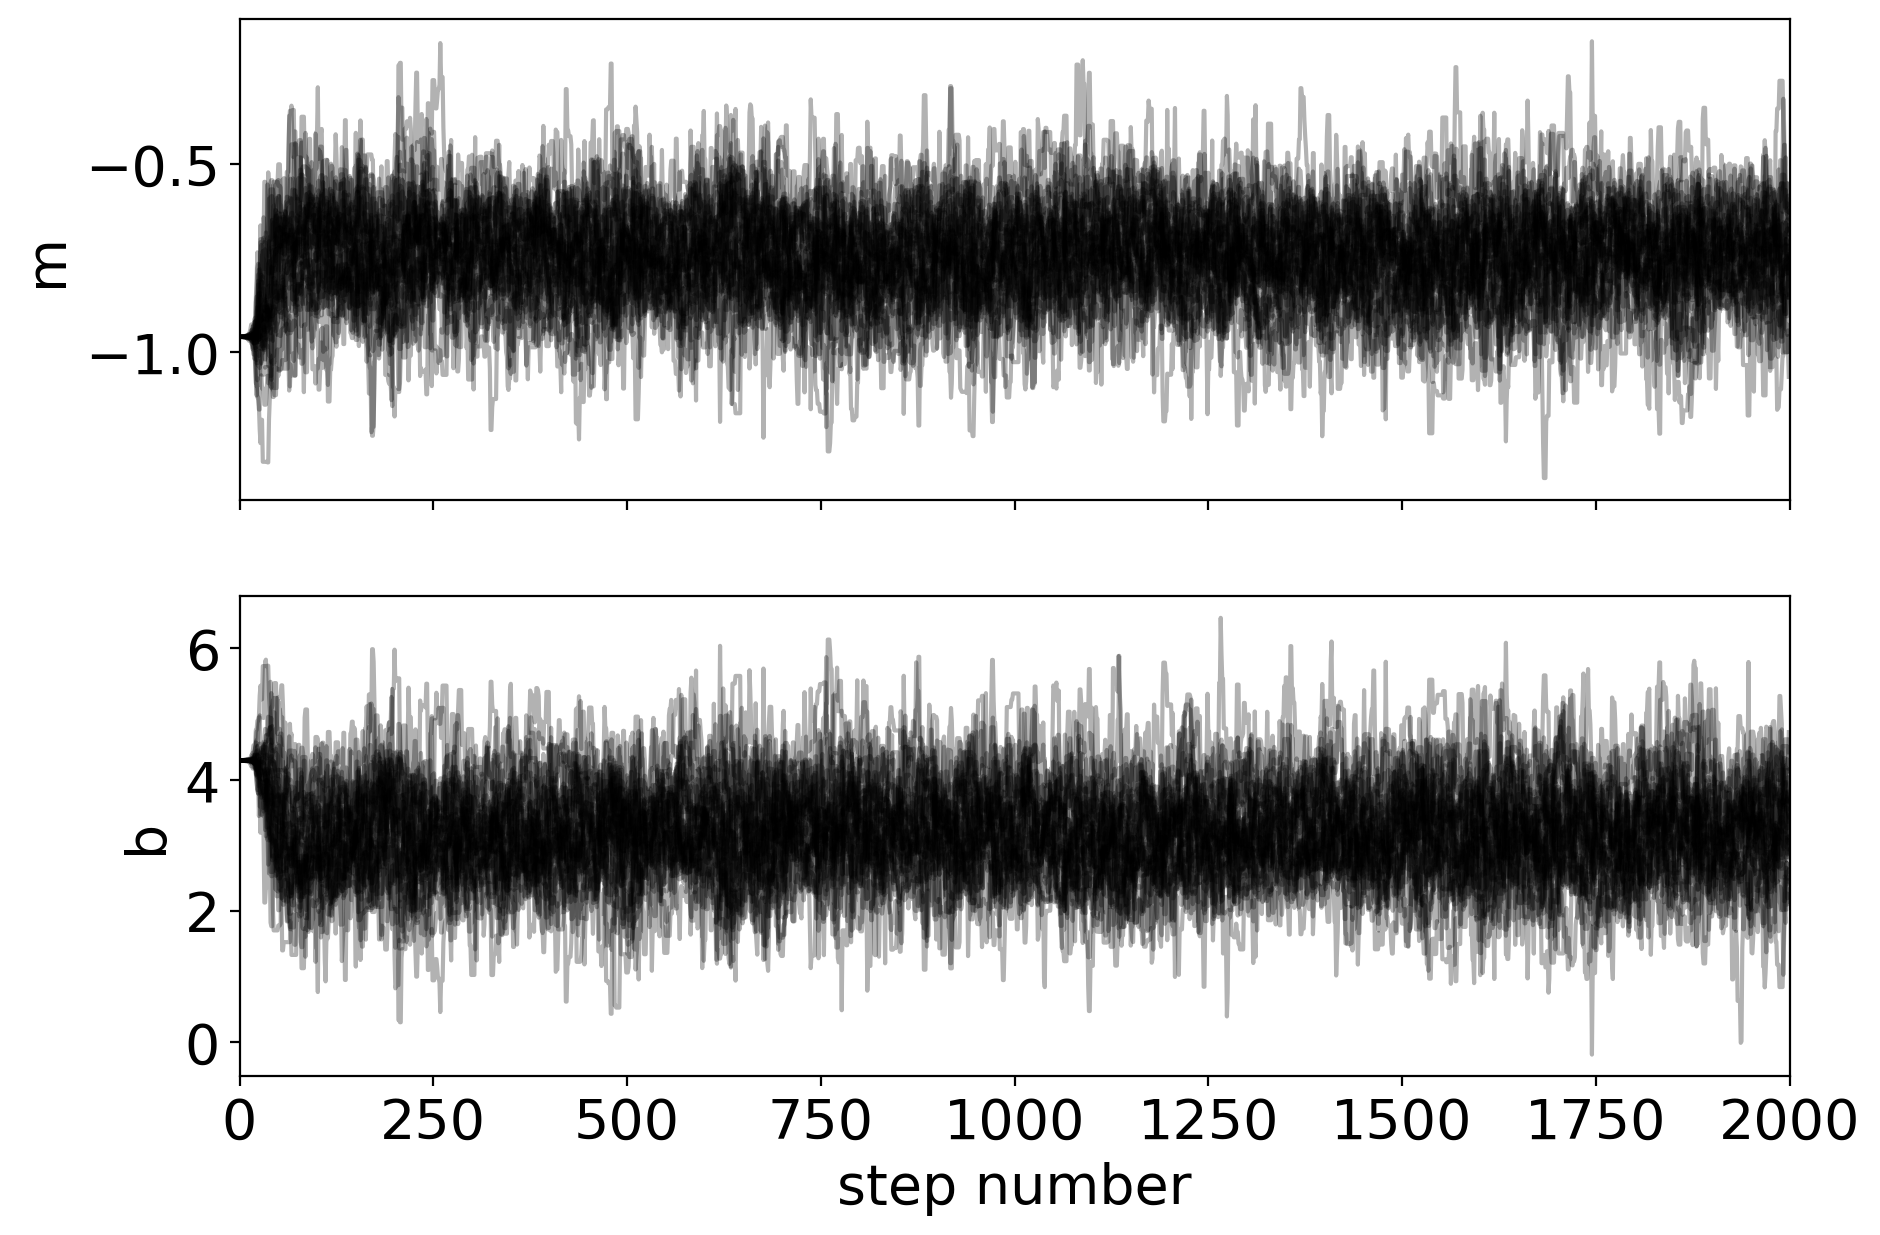

In [7]:
# from bioscrape.pid_interfaces import 
from bioscrape.inference import py_inference

# Import data from CSV
# Import a CSV file for each experiment run
prior = {'m' : ['gaussian', m_true, 500],'b' : ['gaussian', b_true, 1000]}
sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['y'],
                     time_column = ['x'], params_to_estimate = ['m','b'],
                      nwalkers = 32, nsteps = 2000, init_seed = 1e-4, prior = prior,
                      sim_type = 'deterministic', plot_show = False)

# Recommended to simply use sampler object/mcmc_results.csv and generate your own custom plots
truth_list, uncertainty_list = pid.plot_mcmc_results(sampler);

Finally, let us use the samples from the posterior distributions of the parameters alongside our original model and the data:

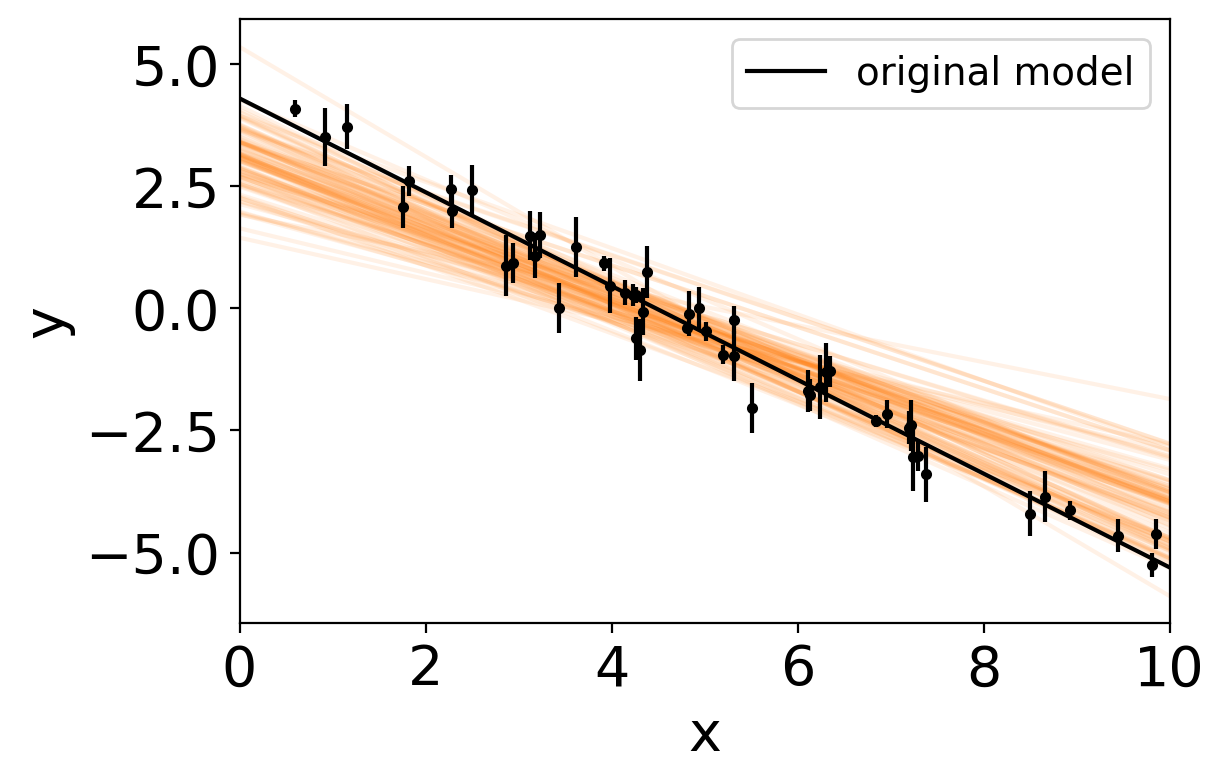

In [8]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="original model")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Great! That's our first MCMC run using Bioscrape. Let us try some more examples to learn about various Bioscrape Inference features. We start by making a slightly more complicated model:

# A Birth-Death Model

## $\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

This time instead of creating the model from scratch, we import an **SBML** model into Bioscrape. SBML is the standard language used to write biological models. Here we have the SBML file "toy_sbml_model.xml" in our path already. For details on how to create this file using Bioscrape, refer to the "Basic Examples -- START HERE.ipynb" in `bioscrape/examples`. 

creating an ensemble sampler with threads= 1


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 579.81it/s]
C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


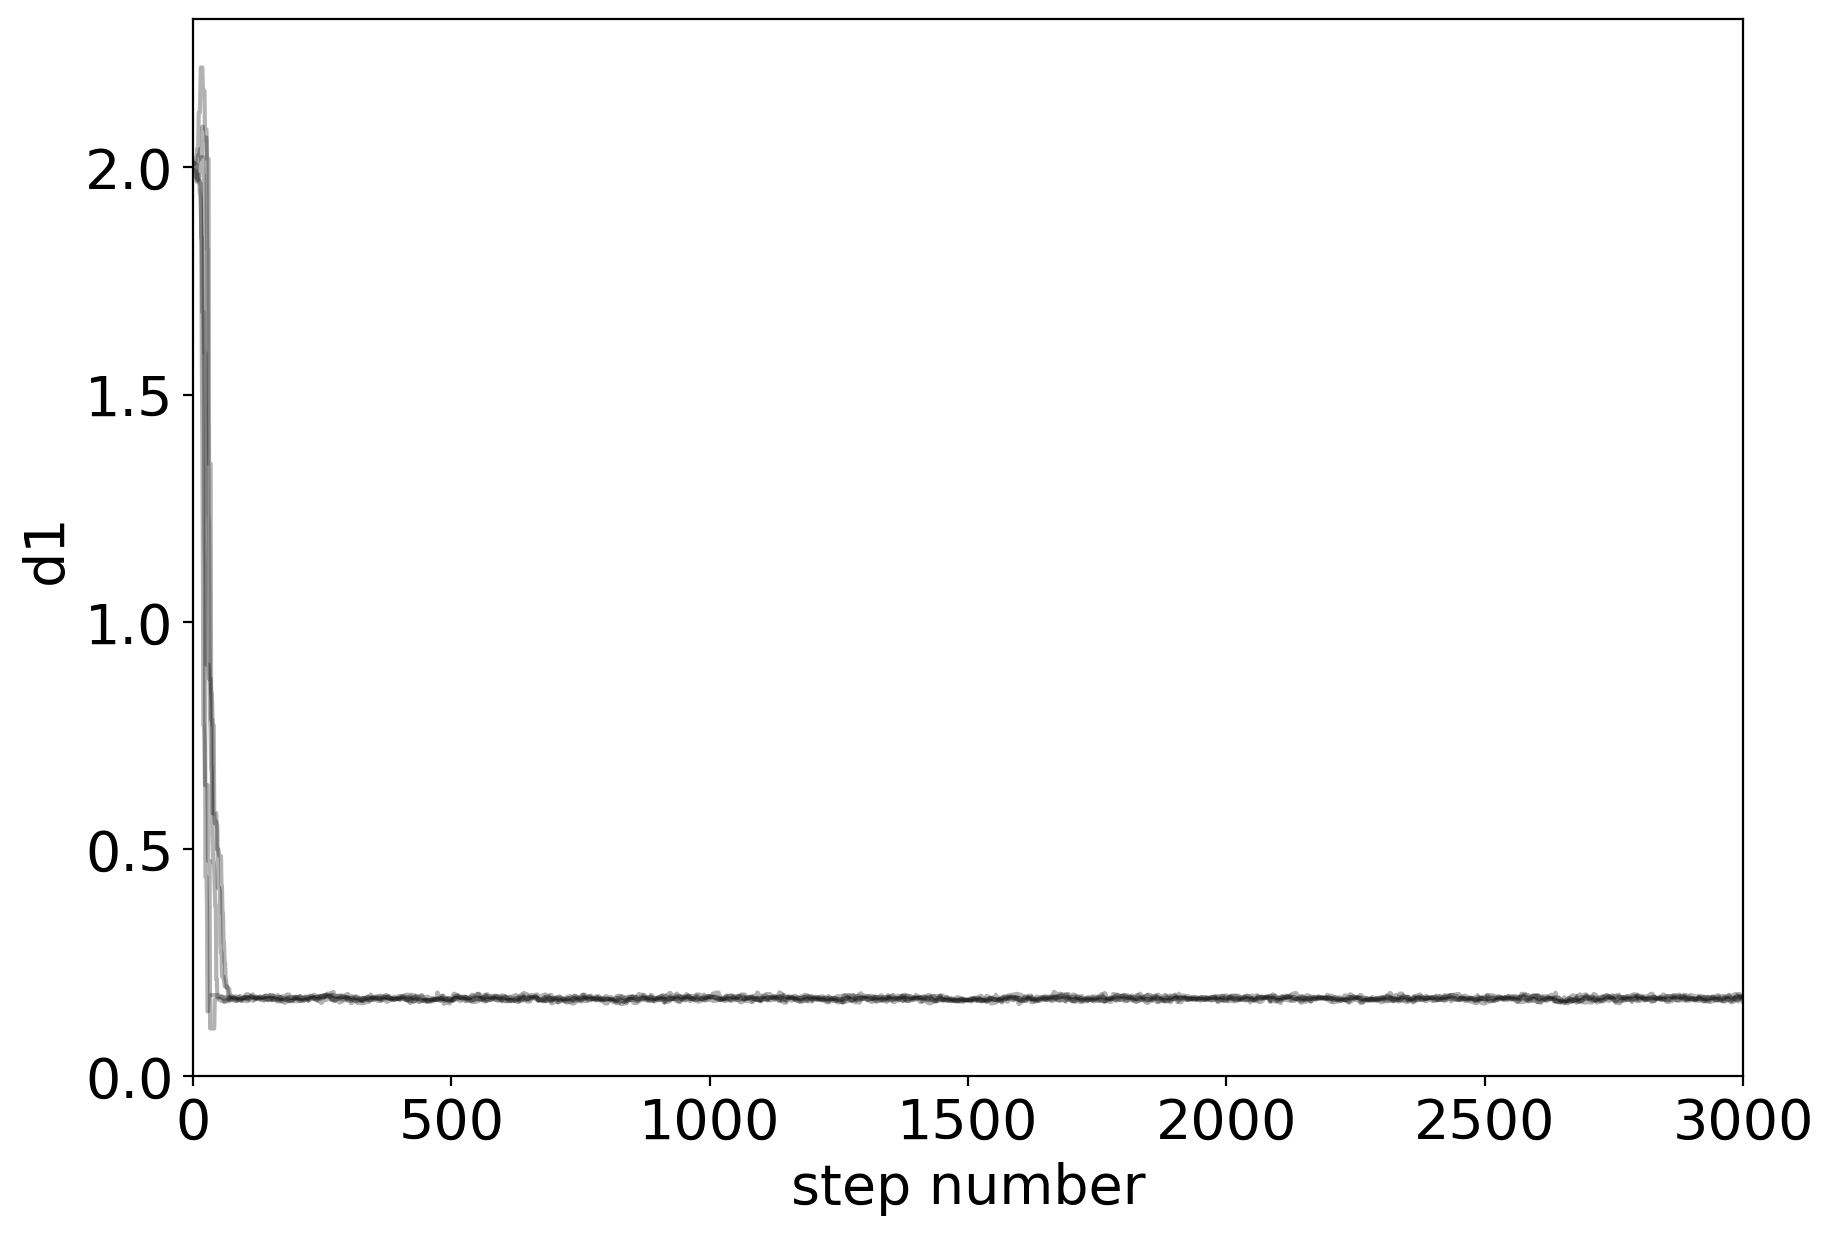

In [9]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.inference import py_inference
import numpy as np
import pylab as plt
import pandas as pd
# Import a bioscrape/SBML model
M = Model(sbml_filename = 'models/toy_sbml_model.xml')
# Import data from CSV
# Import a CSV file for each experiment run
df = pd.read_csv('data/test_data.csv', delimiter = '\t', names = ['X','time'], skiprows = 1)
M.set_species({'X':df['X'][0]})

# Create prior for parameters
prior = {'d1' : ['gaussian', 0.2, 200]}
sampler, pid = py_inference(Model = M, exp_data = df, measurements = ['X'], time_column = ['time'],
            nwalkers = 5, init_seed = np.array([2]), nsteps = 3000, sim_type = 'deterministic',
            params_to_estimate = ['d1'], prior = prior)


Note that we only estimated one parameter here - $d$, and for that parameter we created a Gaussian distribution prior. Bioscrape inference provides plenty of probability distributions built-in to be used as parameter prior distributions. To learn more refer to the "Priors in Bioscrape Inference.ipynb" in `bioscrape/inference examples/`. Now, let us try to estimate both the parameters of our birth-death model:

creating an ensemble sampler with threads= 1


100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:30<00:00, 182.02it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


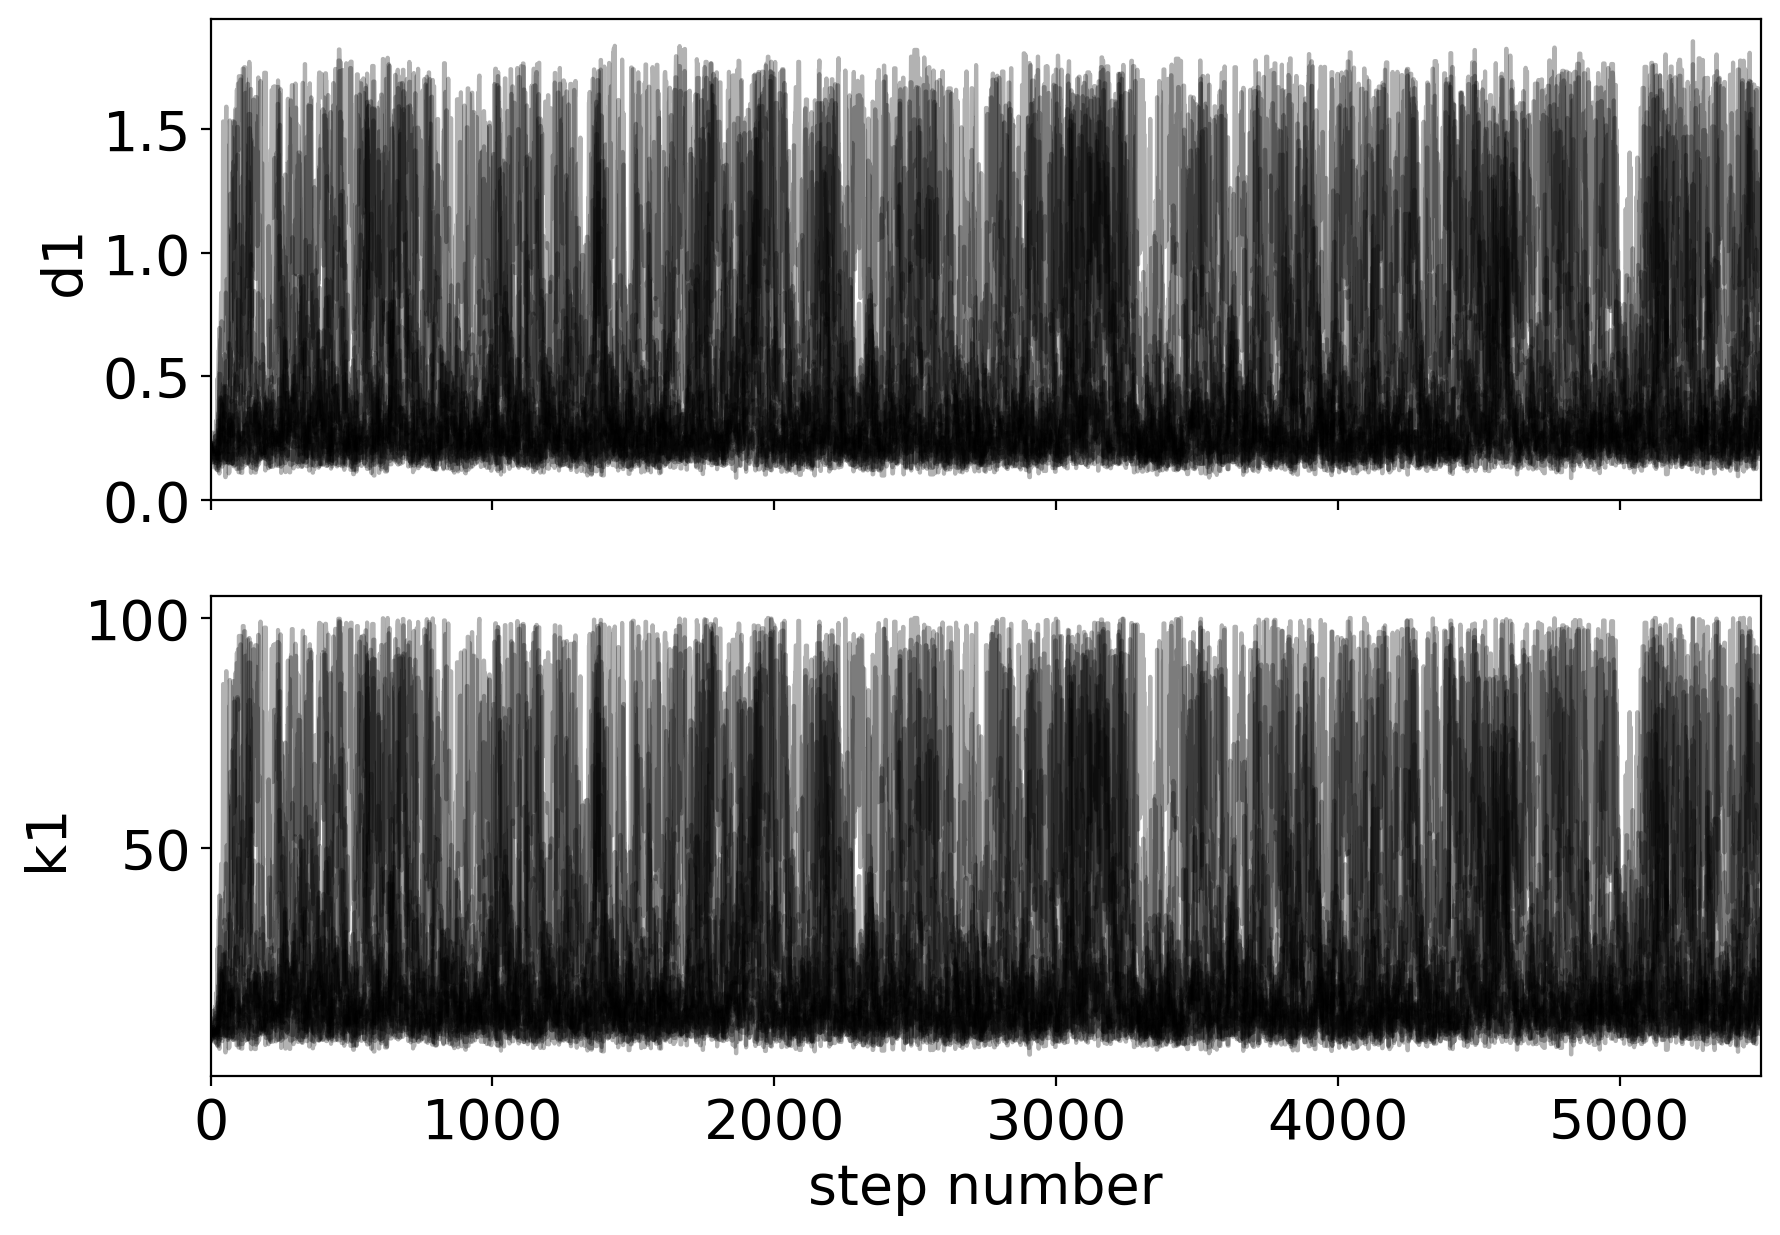

In [10]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.inference import py_inference

import numpy as np
import pylab as plt
import pandas as pd
# Import a bioscrape/SBML model
M = Model(sbml_filename = 'models/toy_sbml_model.xml')
# Import data from CSV
# Import a CSV file for each experiment run
df = pd.read_csv('data/test_data.csv', delimiter = '\t', names = ['X','time'], skiprows = 1)
M.set_species({'X':df['X'][0]})

prior = {'d1' : ['gaussian', 0.2, 20], 'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = df, measurements = ['X'], time_column = ['time'],
            nwalkers = 20, init_seed = 0.15, nsteps = 5500, sim_type = 'deterministic',
            params_to_estimate = ['d1', 'k1'], prior = prior)


## Tip: All of the MCMC run results are written to the `mcmc_results.csv` file after a run. You can check that file out to run your own analysis!.

A common scenario with parameter estimation is that we usually have replicates of the data leading to multiple trajectories in the data that need to be fitted to a single model at the same time. Bioscrape inference allows for such a use case natively. Simply send in more data! Here's how: (let's first generate data with multiple trajectories)

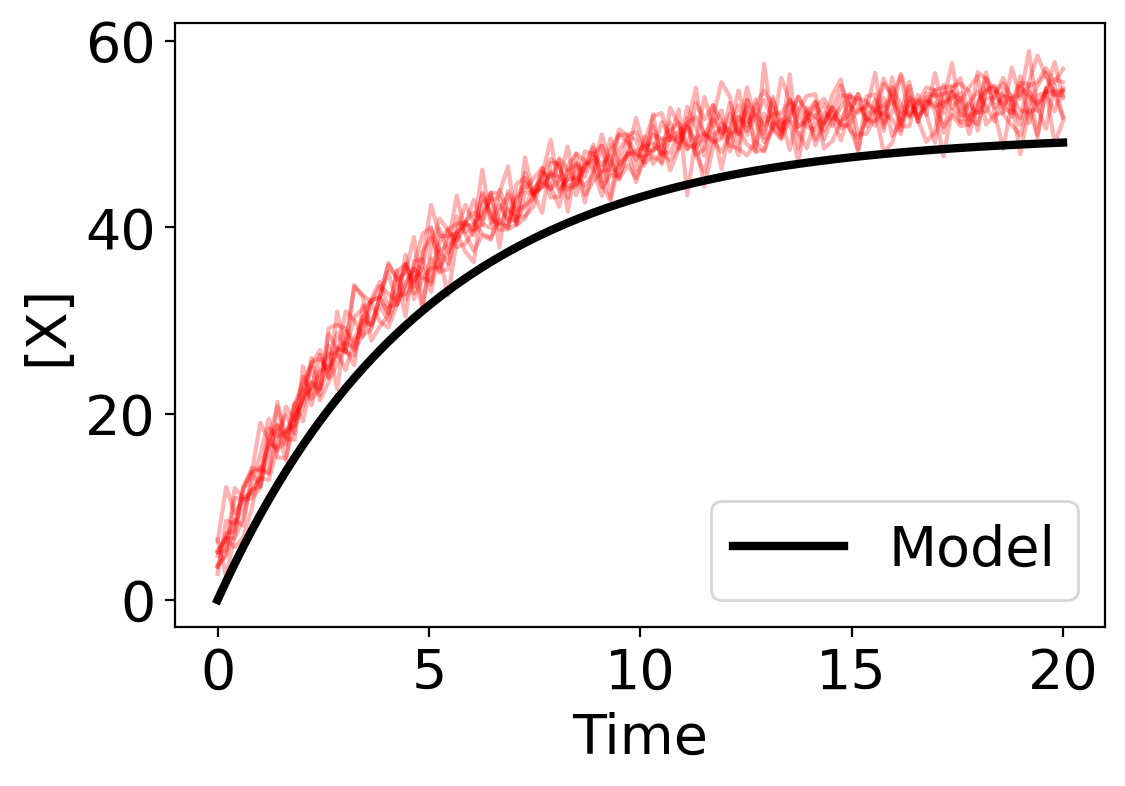

In [11]:

M = Model(sbml_filename = 'models/toy_sbml_model.xml')
timepoints = np.linspace(0,20,100)
result = py_simulate_model(timepoints, Model = M)['X']

num_trajectories = 10
exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result + np.random.normal(5, 2, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
plt.plot(timepoints, result, 'k', linewidth = 3, label = 'Model')
plt.legend()
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()


In [12]:
exp_data.to_csv('data/birth_death_data.csv')
exp_data

timepoints         X0         X1         X2         X3         X4  \
0     0.000000   2.799868   3.560234   5.160689   3.548884   6.502809   
1     0.202020   8.506323   6.718474   6.544544   4.940812   2.511285   
2     0.404040   8.191093   8.595812   5.670414  10.966159   7.016502   
3     0.606061  11.825547   7.949569   6.699974  10.777037  11.809987   
4     0.808081  14.180350  13.651403   9.781317  10.915126  13.667237   
..         ...        ...        ...        ...        ...        ...   
95   19.191919  55.421813  55.169286  54.019883  58.923285  52.689730   
96   19.393939  49.600514  55.598076  53.072882  52.480798  49.890849   
97   19.595960  54.786000  57.078575  54.658899  54.641454  54.969486   
98   19.797980  55.883711  55.533420  54.613785  54.157673  49.016611   
99   20.000000  55.564748  57.003120  54.680956  51.762366  51.391594   

           X5         X6         X7         X8         X9  
0    6.281735   4.729273   3.760830   5.332298   5.074924  
1   12.114381   7.170491   4.733078   6.679009   5.322778  
2    9.339288   7.361516   8.060865   6.580690  12.000896  
3   10.738771  12.218489  10.075419   8.767999  10.958932  
4   11.729222  13.784510  11.796467  12.677361  11.496616  
..        ...        ...        ...        ...        ...  
95  52.329771  51.185081  54.536010  55.559762  53.001481  
96  52.772155  54.141193  53.246906  58.413801  55.181492  
97  50.562645  54.512266  54.361123  56.196981  56.585958  
98  55.287252  57.721017  52.427914  54.206928  54.269491  
99  51.843392  53.864231  54.934172  54.155812  54.612761  

[100 rows x 11 columns]

With that data written to a CSV file, we can load that CSV file and run inference:

creating an ensemble sampler with threads= 1


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:04<00:00, 62.47it/s]
C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


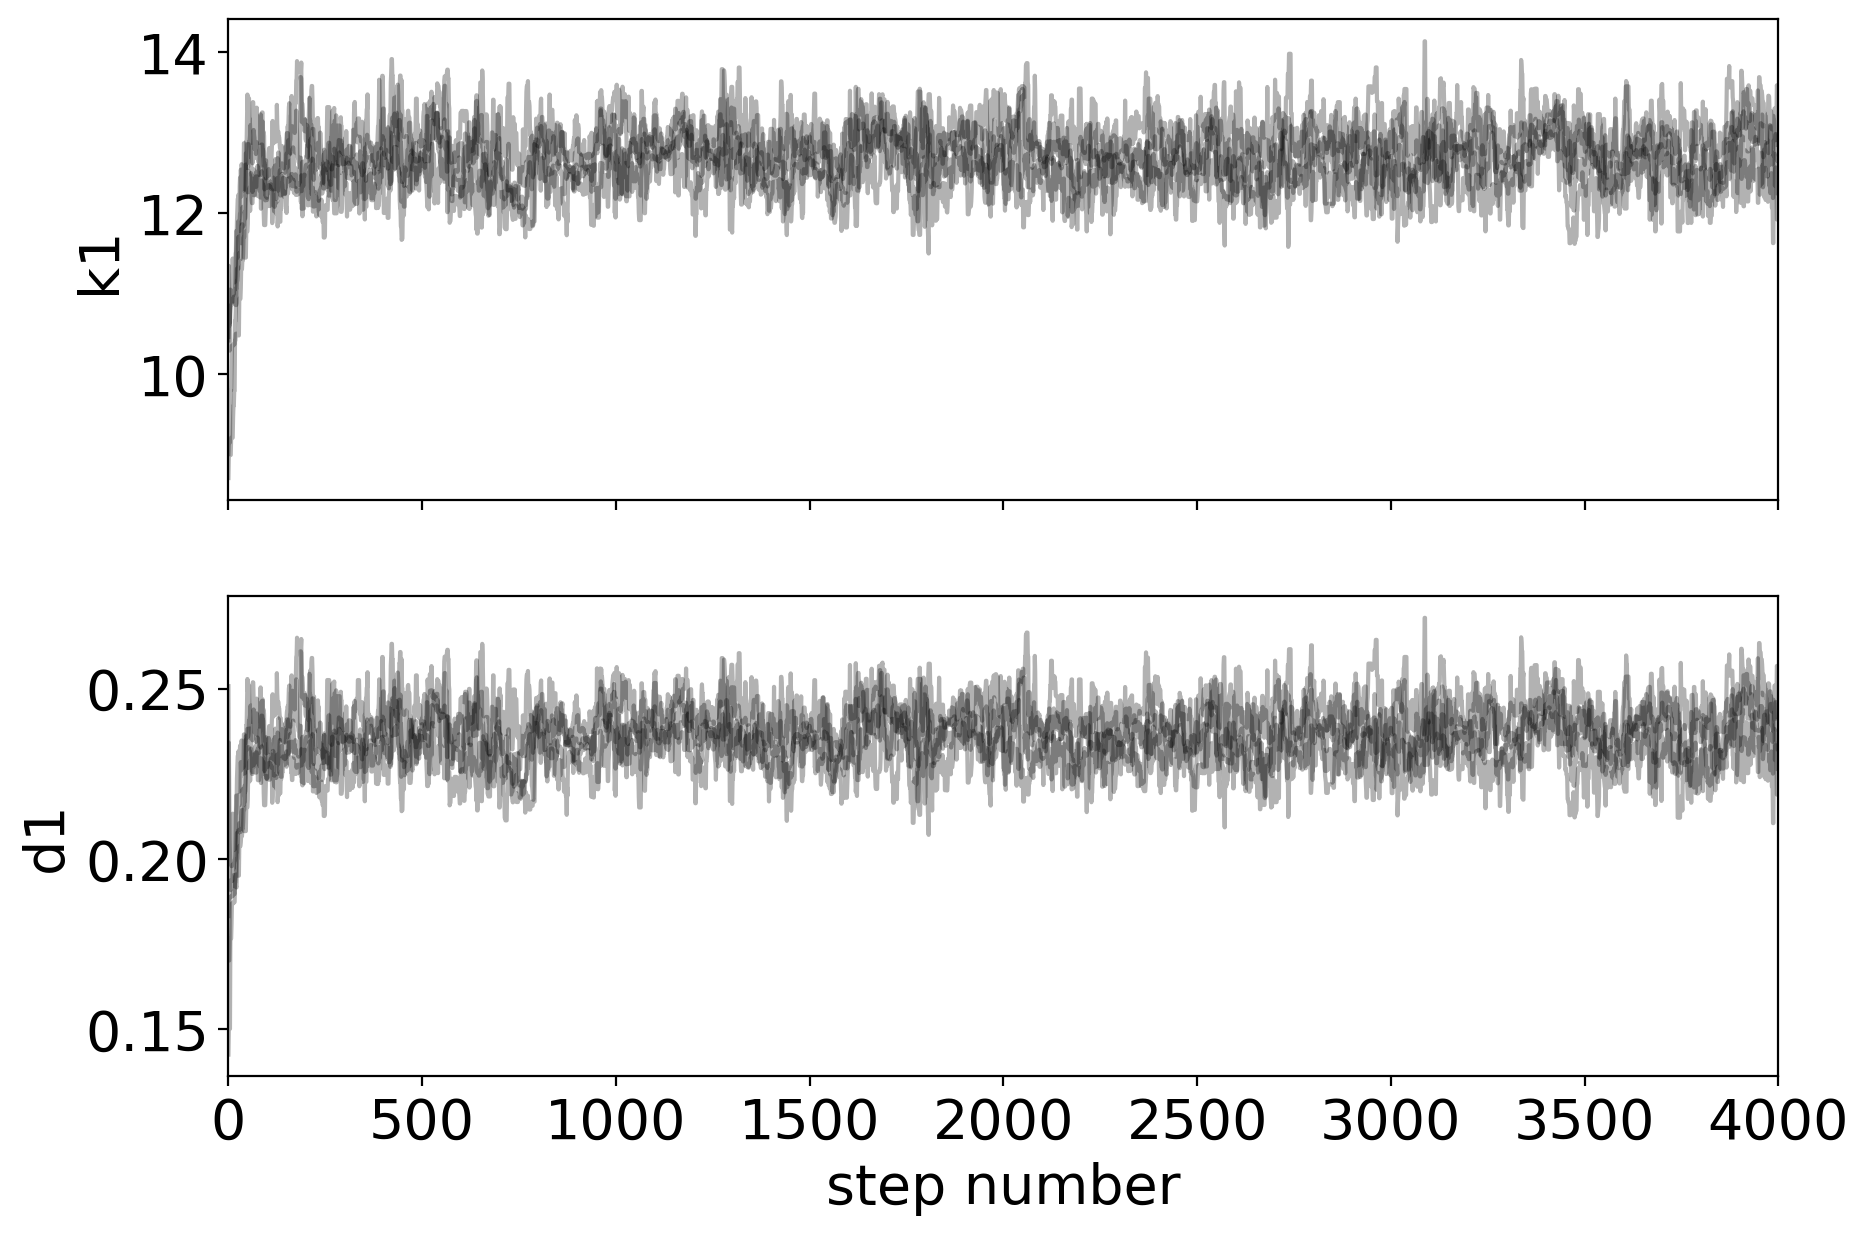

In [13]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
 
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
            nwalkers = 5, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
            params_to_estimate = ['k1', 'd1'], prior = prior)


### Note: A bioscrape inference run using `py_inference` returns a tuple consisting of the `sampler` and a `pid` object. The `sampler` is a emcee object that can be used for any post-processing whereas `pid` is the bioscrape inference object that consists of all of your previous settings. You can use these returned objects for post processing and plotting as follows:

Parameter posterior distribution convergence plots:


C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


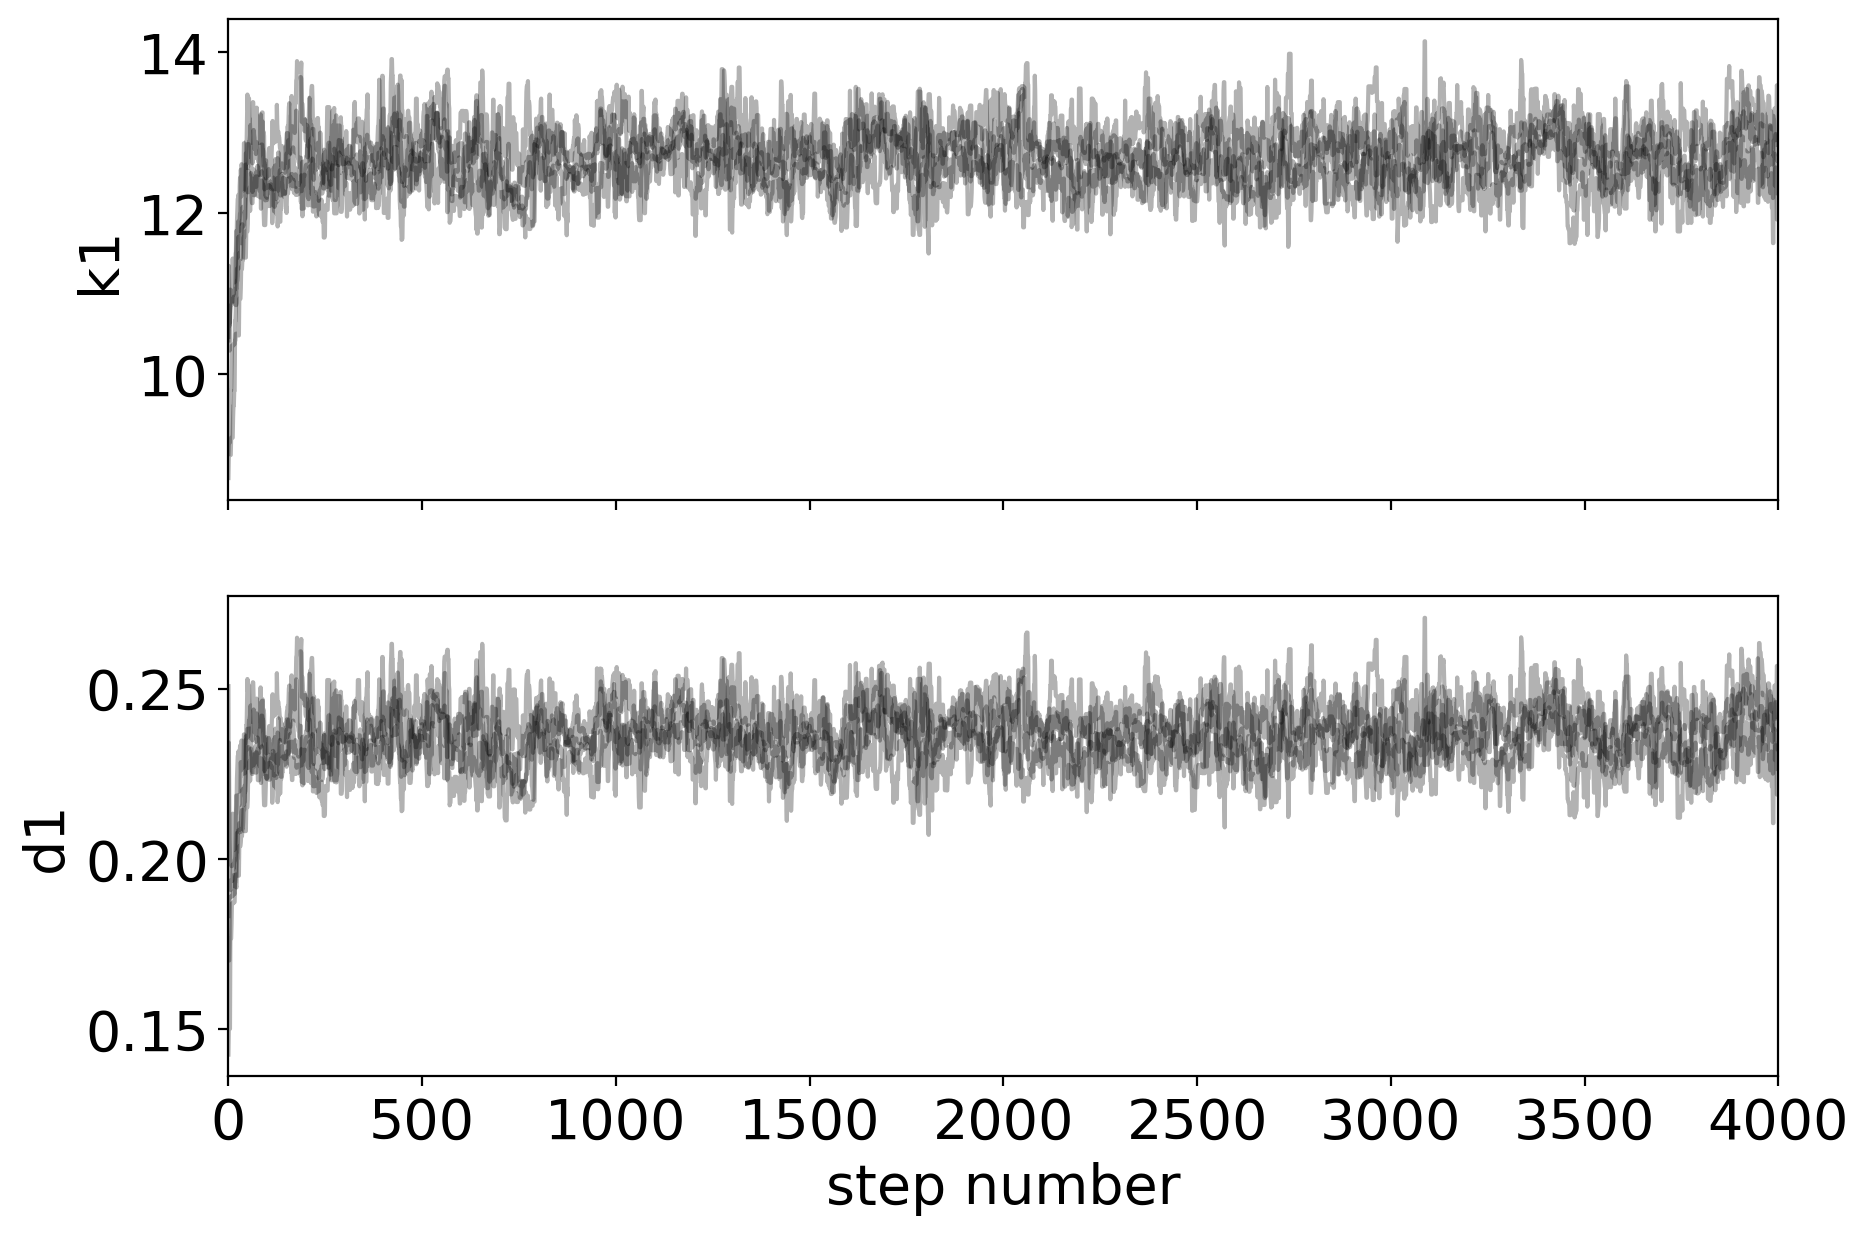

In [14]:
pid.plot_mcmc_results(sampler);

As before, we can sample the posterior distribution and run the simulations for this fitted model alongside the data:

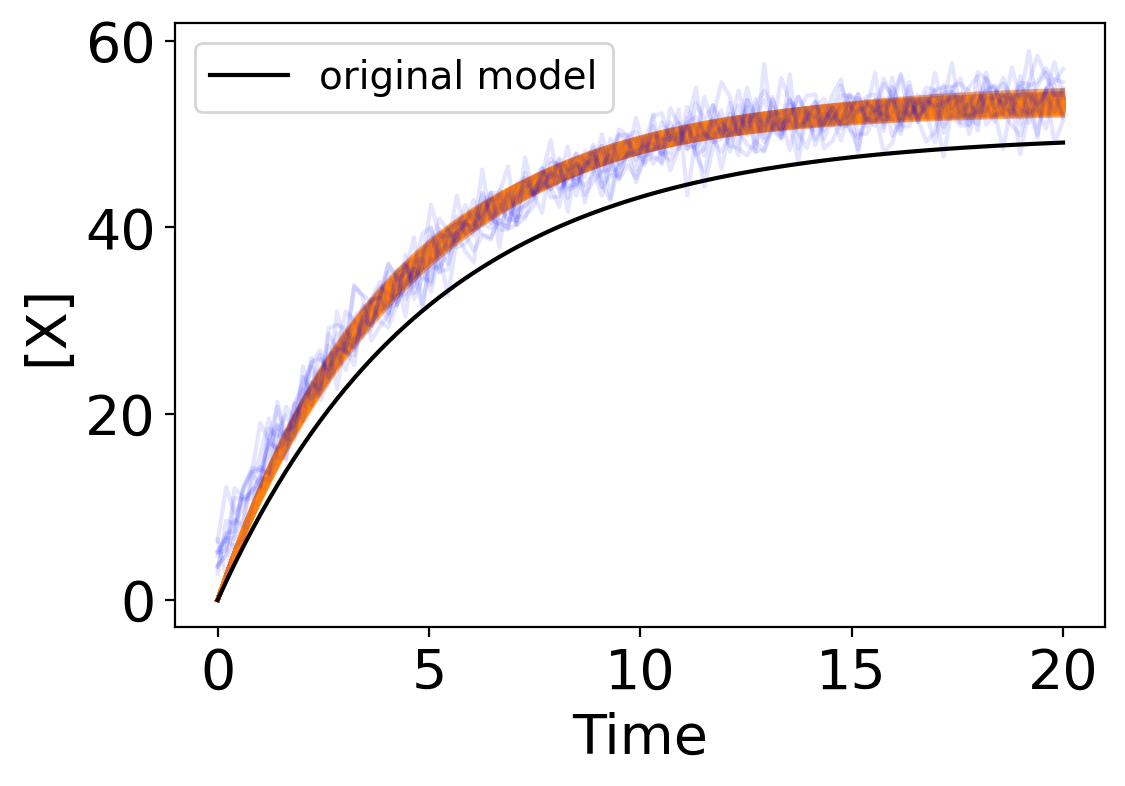

In [15]:
M_fit = Model(sbml_filename='models/toy_sbml_model.xml')
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    for pi, pi_val in zip(pid.params_to_estimate, sample):
        M_fit.set_parameter(pi, pi_val)
    plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
plt.plot(timepoints, result, "k", label="original model")
plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

# Starting the MCMC chain at different initial points (init_seed):

The `init_seed` keyword argument to `py_inference` can be either of the two things:
* A float value - In this case, the float value passed is used as the scaling factor for a Gaussian ball around the initial parameter values already set in the Bioscrape Model object.
* A numpy array - In this case, you can directly pass the initial parameter values to the sampler. This array consists of the values where the sampler starts sampling.

## Tip: Start at different initial conditions for your parameters and if you end up in the same region you can have higher confidence on convergence of your chain.

Let's try a different initial seed for the above example

creating an ensemble sampler with threads= 1


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.72it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


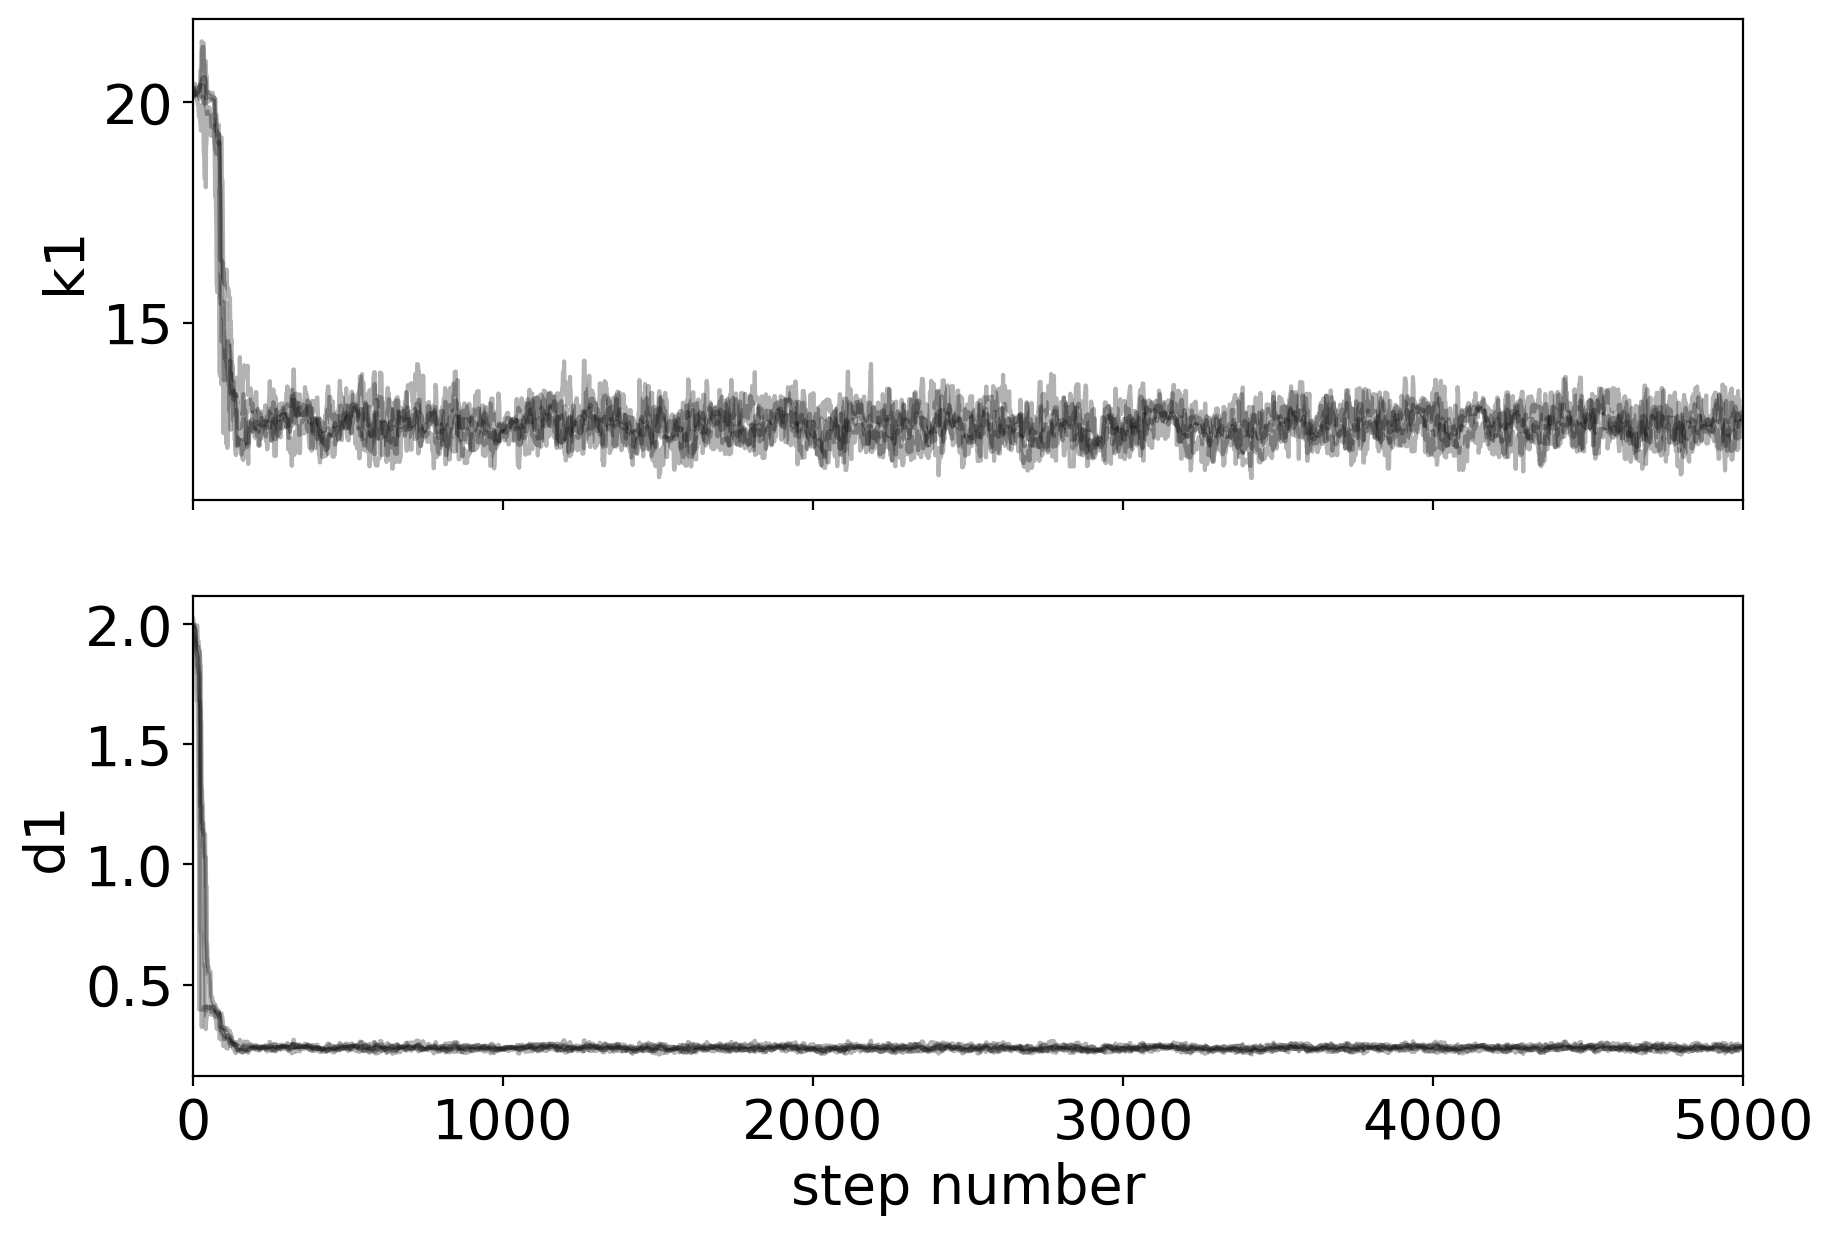

In [19]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
 
prior = {'k1' : ['uniform', 0, 100],'d1' : ['uniform',0,10]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
            nwalkers = 5, init_seed = np.array([20, 2]), nsteps = 5000, sim_type = 'deterministic',
            params_to_estimate = ['k1', 'd1'], prior = prior)


## An inner look:

Bioscrape inference computes a cost that is used as the likelihood function for emcee. The MCMC chain aims to minimize this cost. An invaluable tool when running Bayesian inference could be to look at the progression of this cost. This may help you in judging the convergence of the MCMC sampler. On the topic of convergence, as you may have noted in our earlier inference runs, a list of convergence related statistics is printed after the run finishes successfully. Make sure to learn more about these MCMC convergence diagnostics to understand better if your inference run has converged or not. Here is how to check the cost progress:

### Likelihood cost progress (with number of steps in the chain):

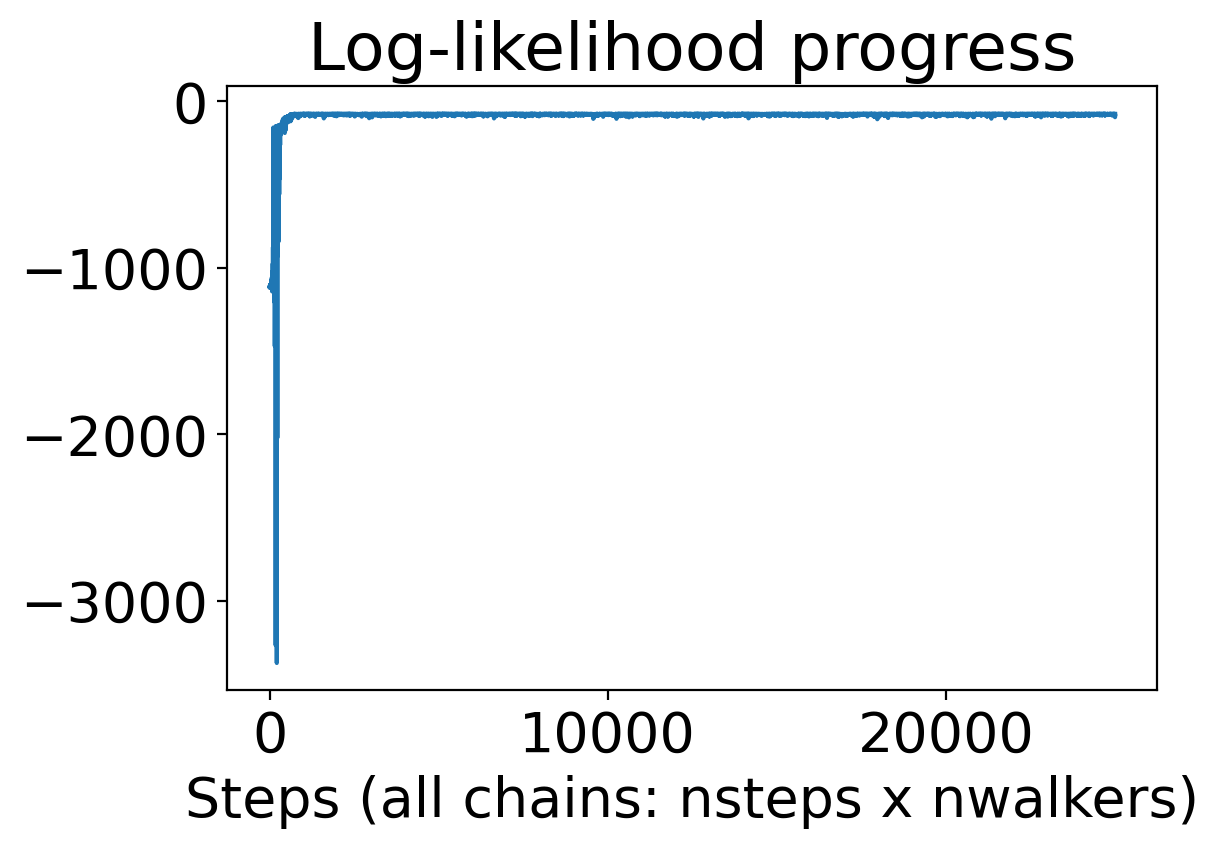

In [20]:
plt.close()
plt.title('Log-likelihood progress')
plt.plot(pid.cost_progress)
plt.xlabel('Steps (all chains: nsteps x nwalkers)')
plt.show()

The `cost_progress` above can be related to `cost_params`. Both are numpy arrays of same size. This can help you find out the parameter set that led to a particular cost that you are interested in (like finding parameters that give minimum cost). Both `cost_progress` and `cost_params` are attributes of the `pid` object. You can also manually plot a histogram of parameter samples using the `cost_params` as below:

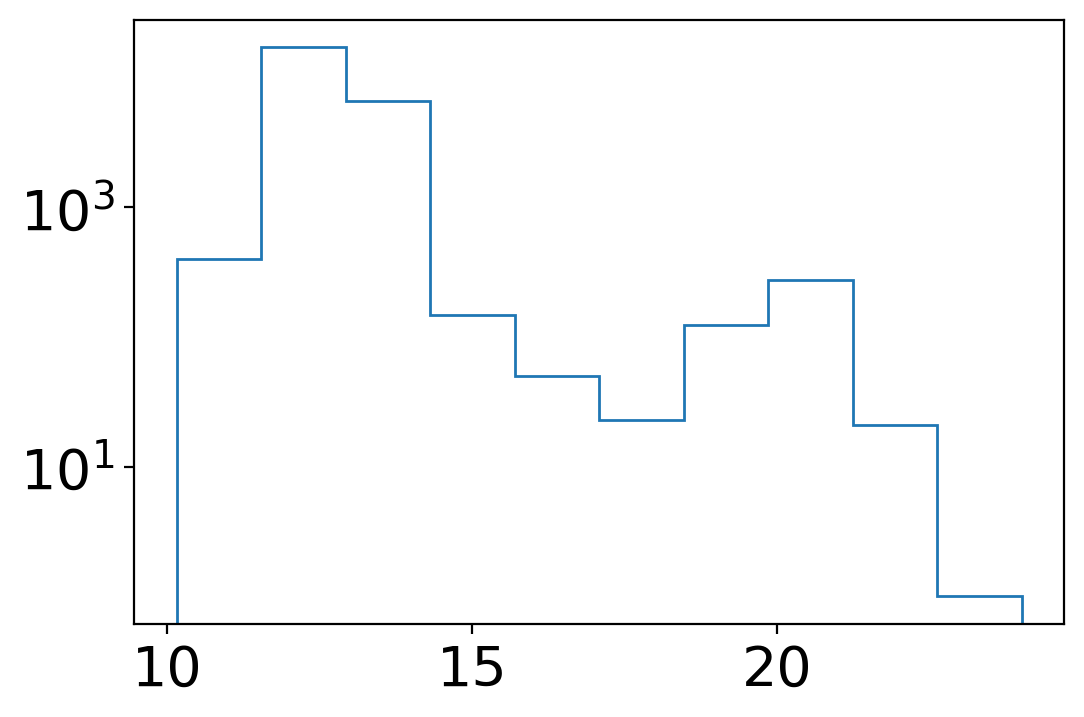

In [21]:
p1_samples = []
for i in range(np.shape(pid.cost_params)[0]):
    p1_samples.append(pid.cost_params[i][0])
plt.hist(p1_samples, histtype = 'step', log=True);

Now that we have seen how to use multiple data trajectories with bioscrape inference, what if those trajectories are under different initial conditions?

# Multiple Initial Conditions:

In our birth-death model, we introduce an inducer species that we will use to demonstrate the effect of different initial conditions.
## $\emptyset \xrightarrow[]{k_1(I)} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$


## $ k_1(I) = \frac{k_1 I^2}{K_R^2 + I^2}$

Here $I$ is the inducer species that may have different initial conditions. 

In [22]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2})]
k1 = 50.0
d1 = 0.5
params = [('k1', k1), ('d1', d1), ('KR', 20)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

### Generate experimental data for multiple initial conditions
1. Simulate bioscrape model
2. Add Gaussian noise of non-zero mean and non-zero variance to the simulation
3. Create appropriate Pandas dataframes 
4. Write the data to a CSV file

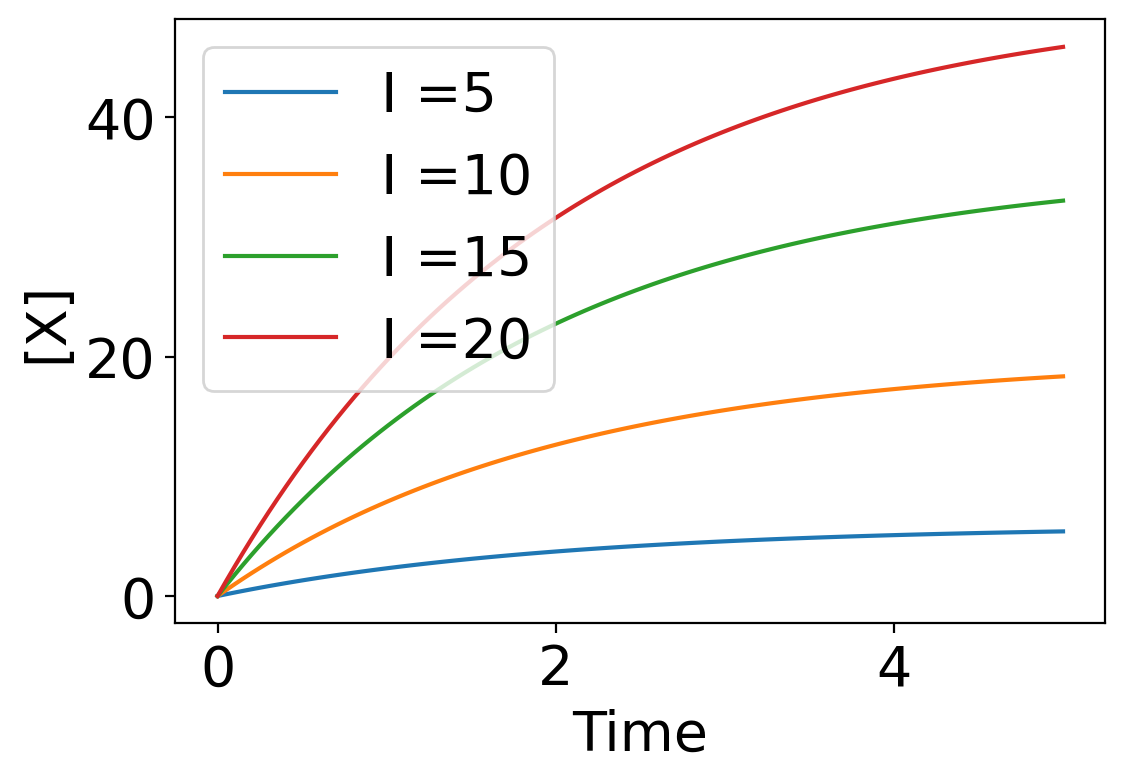

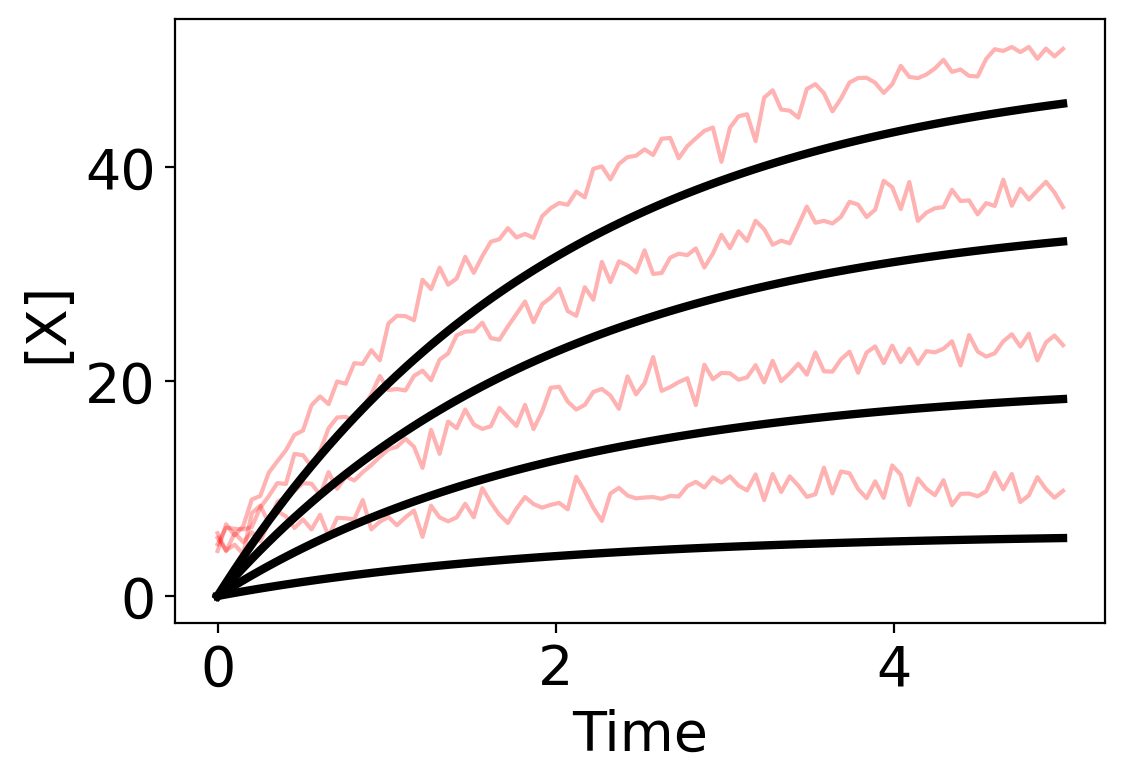

In [23]:

num_trajectories = 4 # each with different initial condition
initial_condition_list = [{'I':5},{'I':10},{'I':15},{'I':20}] 
timepoints = np.linspace(0,5,100)
result_list = []
for init_cond in initial_condition_list:
    M.set_species(init_cond)
    result = py_simulate_model(timepoints, Model = M)['X']
    result_list.append(result)
    plt.plot(timepoints, result, label = 'I =' + str(list(init_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('[X]')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i] + np.random.normal(5, 1, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i], 'k', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
exp_data.to_csv('data/birth_death_data_multiple_conditions.csv')

In [24]:
exp_data

timepoints         X0         X1         X2         X3
0     0.000000   5.855833   5.417017   4.833531   4.195565
1     0.050505   4.175321   4.256462   6.372020   6.684104
2     0.101010   5.879867   4.779470   6.259066   5.653881
3     0.151515   5.027380   3.910175   6.209360   6.503059
4     0.202020   5.942993   7.719810   6.416272   8.985644
..         ...        ...        ...        ...        ...
95    4.797980   9.378836  24.454262  36.951912  51.184270
96    4.848485  11.077592  21.956767  37.800462  50.075998
97    4.898990   9.963815  23.640460  38.608321  51.029871
98    4.949495   9.160365  24.281298  37.612806  50.300572
99    5.000000   9.802545  23.375538  36.247761  51.001582

[100 rows x 5 columns]

## Now run bioscrape inference...

creating an ensemble sampler with threads= 1


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:31<00:00, 125.03it/s]
C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


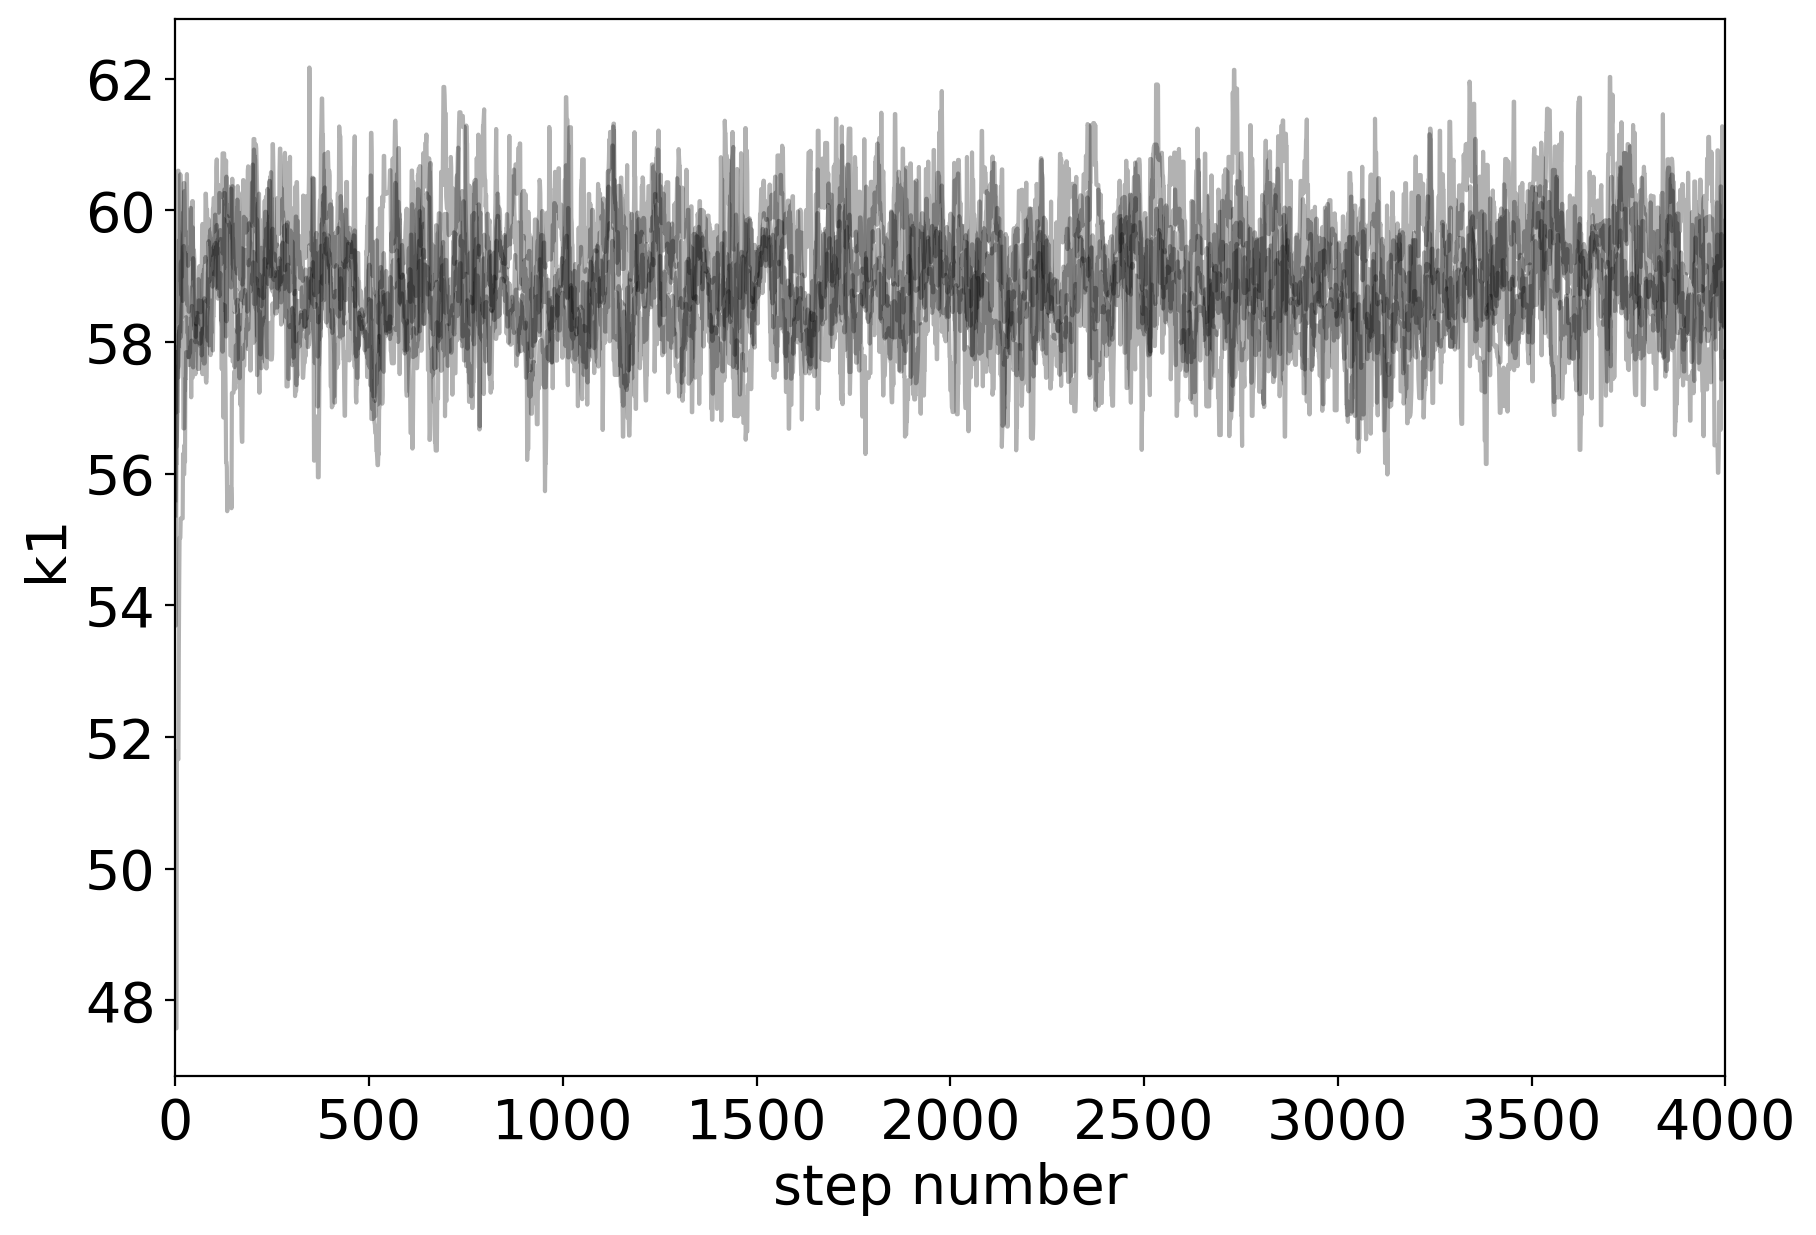

In [25]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data_multiple_conditions.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
    
prior = {'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 5, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
                            params_to_estimate = ['k1'], prior = prior)


As before...

### Check mcmc_results.csv for the results of the MCMC procedure and perform your own analysis.

### OR

### You can also plot the results as follows

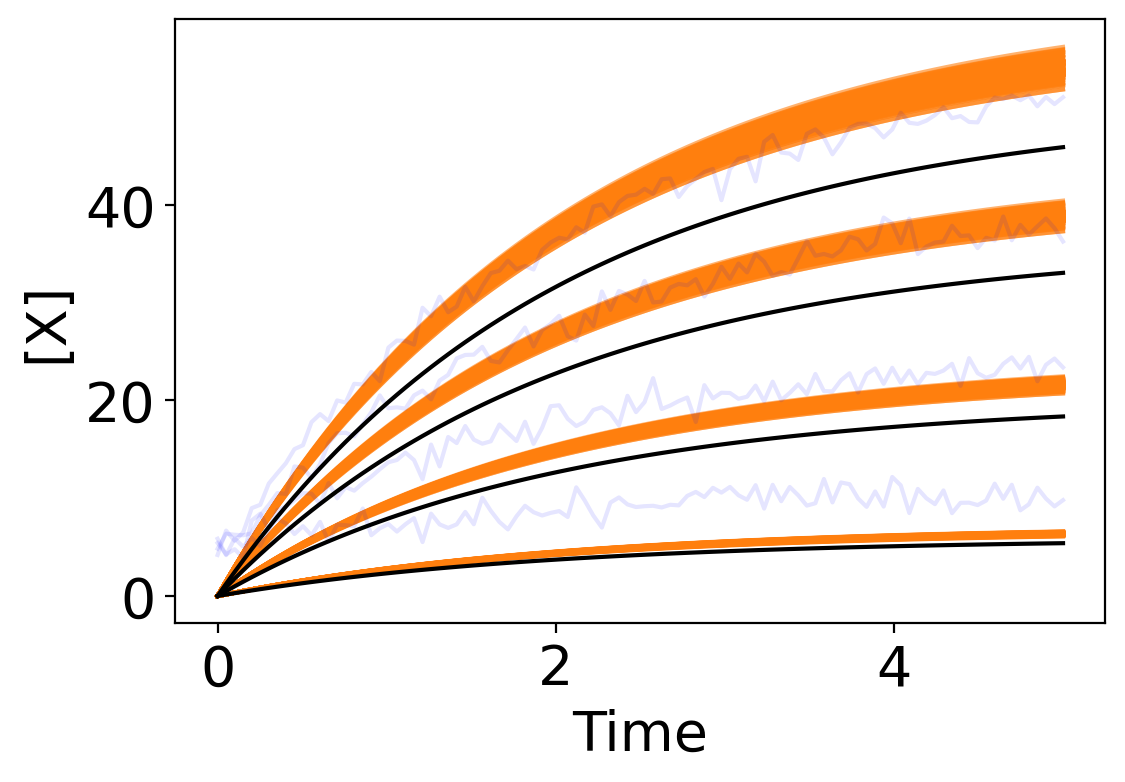

In [26]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for init_cond in initial_condition_list:
    
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        M_fit.set_species(init_cond)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

### Let us now try to fit all three parameters to see if results improve:

creating an ensemble sampler with threads= 1


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:12<00:00, 69.38it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


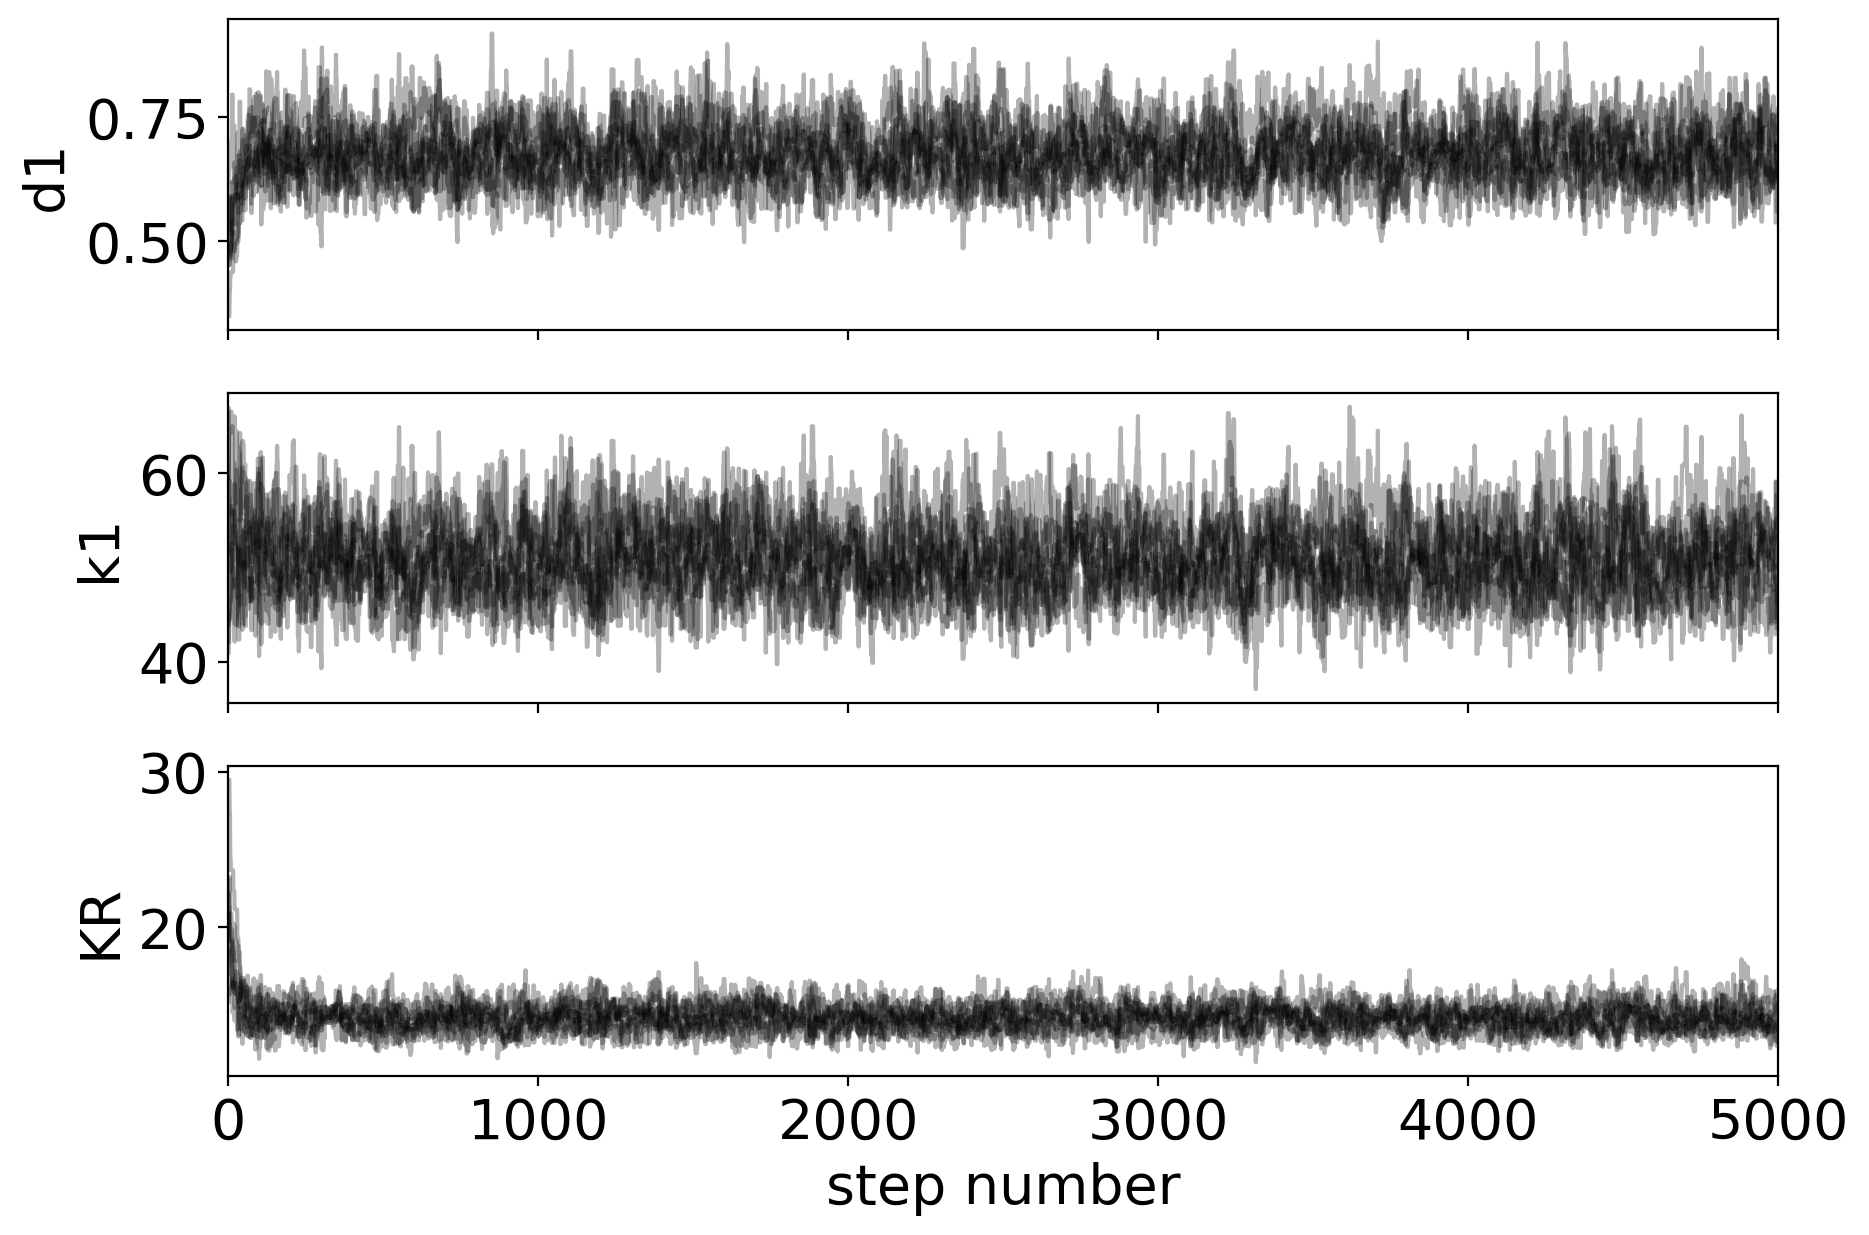

In [27]:
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 10, init_seed = 0.15, nsteps = 5000, sim_type = 'deterministic',
                            params_to_estimate = ['d1','k1','KR'], prior = prior)


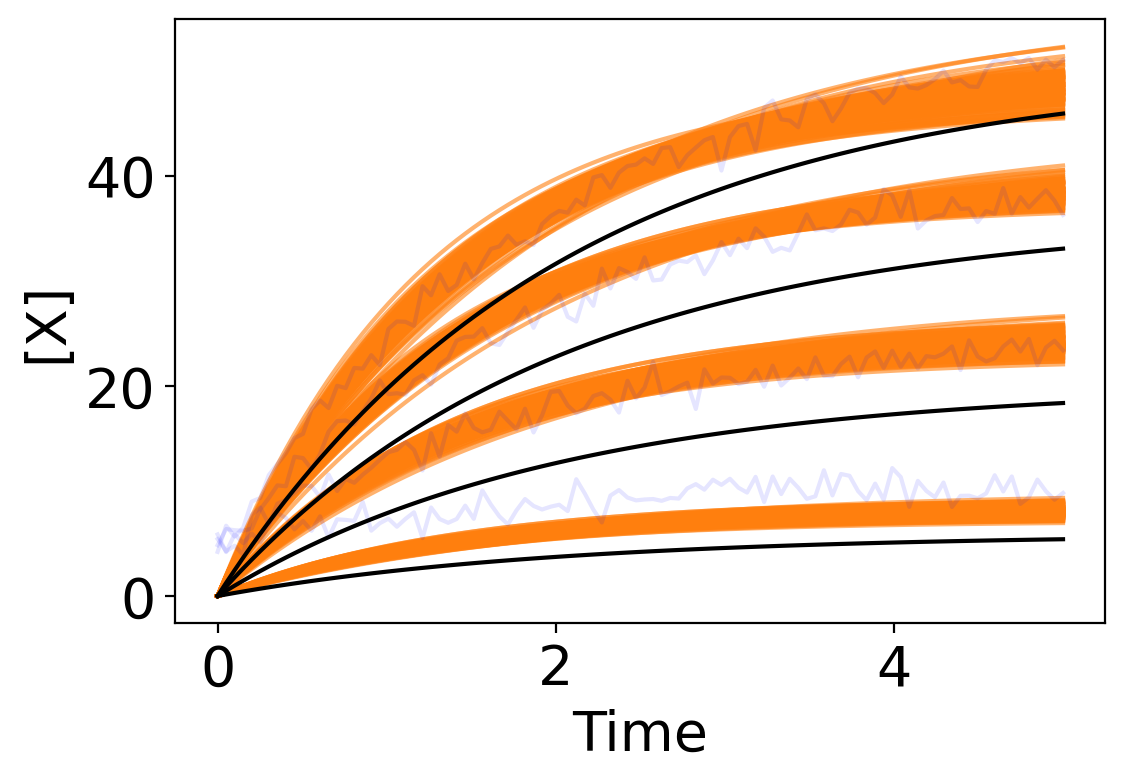

In [28]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=200)
for init_cond in initial_condition_list:
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        M_fit.set_species(init_cond)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

# Parameter conditions for different data trajectories

Instead of initial conditions on model variables, you can choose to use initial conditions on parameters and run parameter inference on other parameters. 

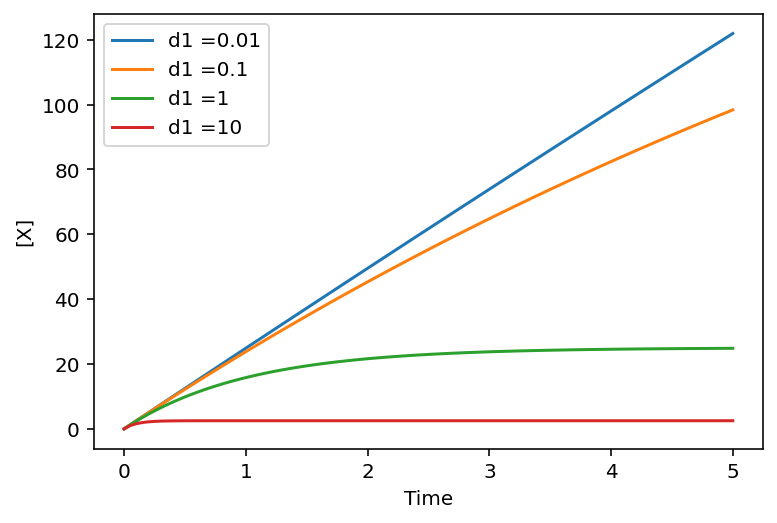

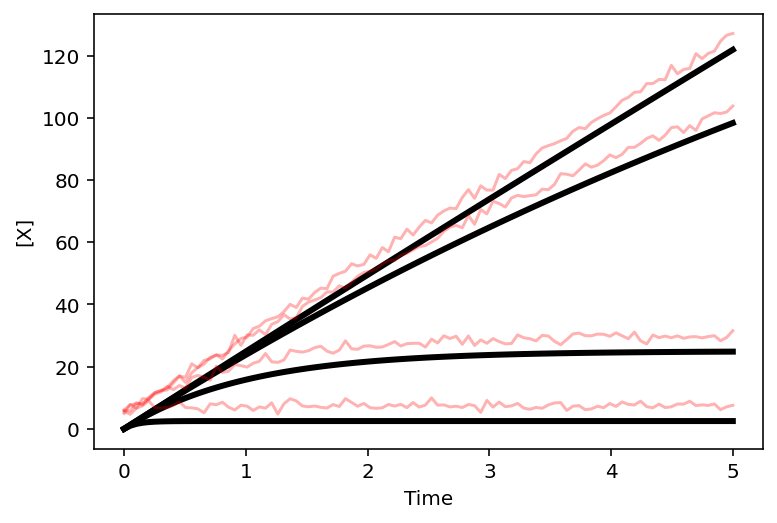

In [43]:
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2})]
k1 = 50.0
d1 = 0.5
params = [('k1', k1), ('d1', d1), ('KR', 20)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)


num_trajectories = 4 # each with different initial condition
parameter_condition_list = [{'d1':0.01},{'d1':0.1},{'d1':1},{'d1':10}] 
timepoints = np.linspace(0,5,100)
result_list = []
M.set_species({"I":20})
for param_cond in parameter_condition_list:
    M.set_params(param_cond)
    result = py_simulate_model(timepoints, Model = M)['X']
    result_list.append(result)
    plt.plot(timepoints, result, label = 'd1 =' + str(list(param_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('[X]')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i] + np.random.normal(5, 1, size = np.shape(result))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i], 'k', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
exp_data.to_csv('data/birth_death_data_multiple_param_conditions.csv')

creating an ensemble sampler with threads= 1


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 147.10it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


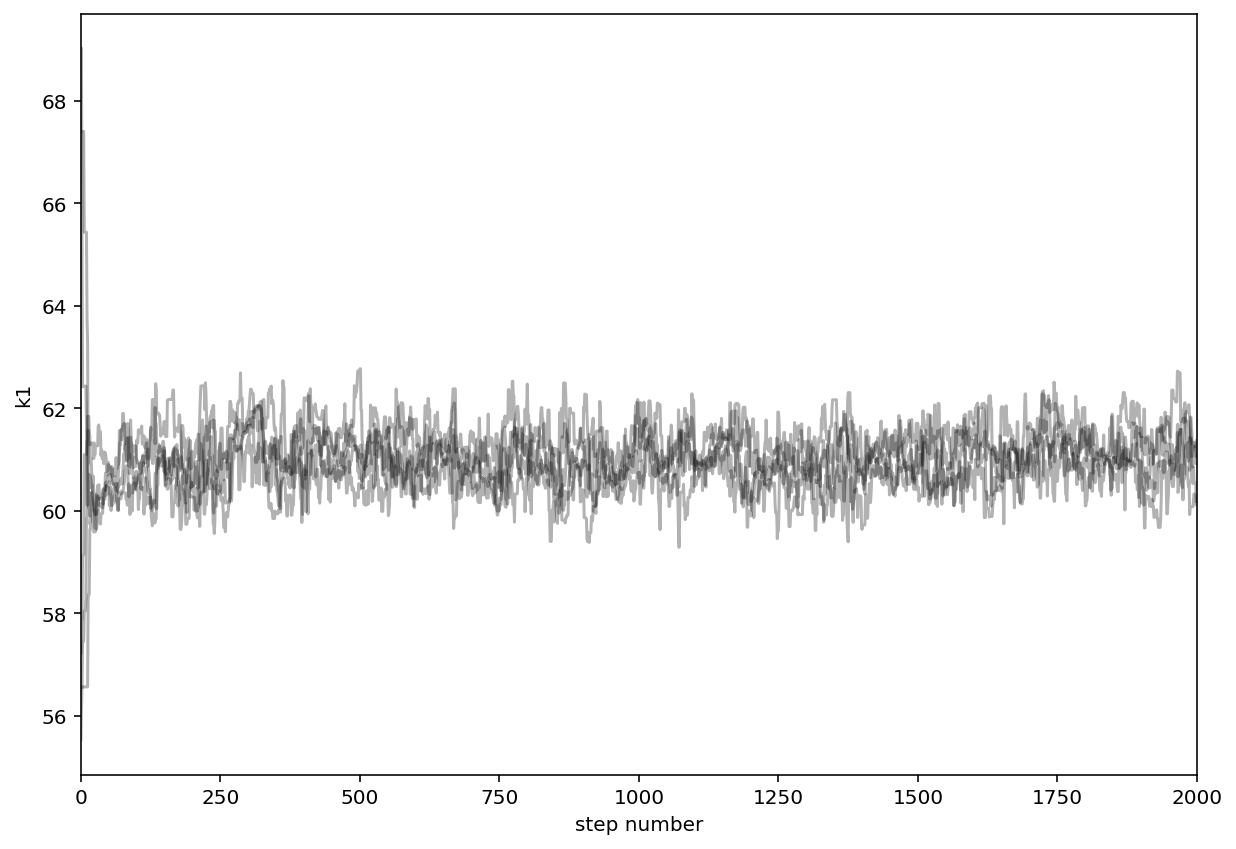

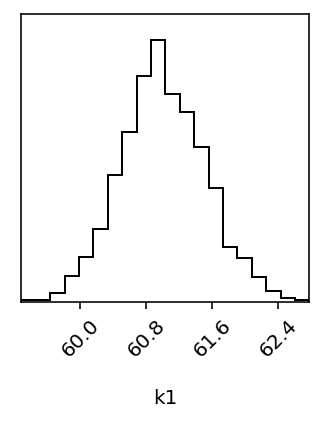

In [56]:
from bioscrape.inference import py_inference
# Import data from CSV
# Import a CSV file for each experiment run
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/birth_death_data_multiple_param_conditions.csv', usecols = ['timepoints', 'X'+str(i)])
    df.columns = ['timepoints', 'X']
    exp_data.append(df)
    
prior = {'k1' : ['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X'], time_column = ['timepoints'],
                            parameter_conditions = parameter_condition_list,
                            nwalkers = 5, init_seed = 0.15, nsteps = 2000, sim_type = 'deterministic', 
                            convergence_check=True,
                            params_to_estimate = ['k1'], prior = prior)


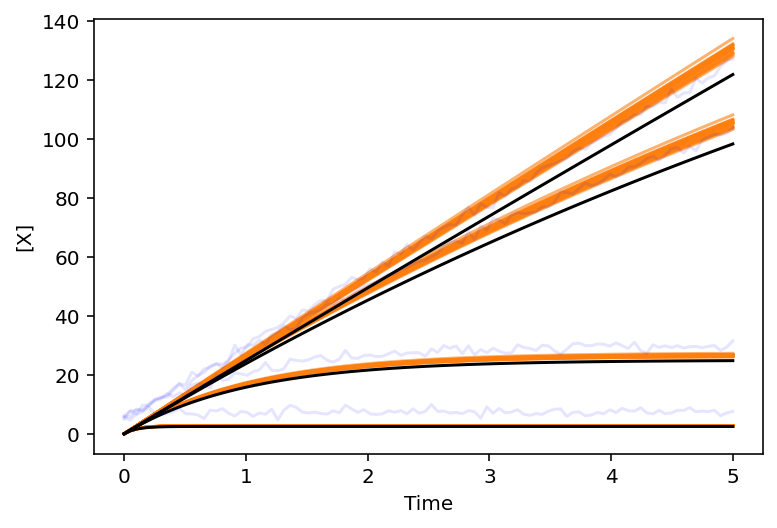

In [57]:
M_fit = M
timepoints = pid.timepoints[0]
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
inds = np.random.randint(len(flat_samples), size=20)
for param_cond in parameter_condition_list:
    M.set_params(param_cond)
    for ind in inds:
        sample = flat_samples[ind]
        for pi, pi_val in zip(pid.params_to_estimate, sample):
            M_fit.set_parameter(pi, pi_val)
        plt.plot(timepoints, py_simulate_model(timepoints, Model= M_fit)['X'], "C1", alpha=0.6)
# plt.errorbar(, y, yerr=yerr, fmt=".k", capsize=0)
for i in range(num_trajectories):
    plt.plot(timepoints, list(pid.exp_data[i]['X']), 'b', alpha = 0.1)
    plt.plot(timepoints, result_list[i], "k")
# plt.legend(fontsize=14)
plt.xlabel("Time")
plt.ylabel("[X]");

In the thread of multiple data trajectories, another common possibility is to have multiple measured species in the data. This is the case when you have measurements for more than one species in the model and you want to fit your model so that it performs well on both measurements. Bioscrape inference allows for this possibility natively. Here's how:

# Multiple Measurements and Initial Conditions (together)

Let's change our model slightly for this to make sense.
## $\emptyset \xrightarrow[]{k_1(I)} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$
## $X \xrightarrow[]{k_2} Y$

## $ k_1(I) = \frac{k_1 I^2}{K_R^2 + I^2}$

In [29]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt
import pandas as pd
species = ['I','X', 'Y']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), 
             ([], ['X'], 'hillpositive', {'s1':'I', 'k':'k1', 'K':'KR', 'n':2}),
             (['X'],['Y'],'massaction', {'k':'k2'})]
k1 = 50.0
d1 = 0.5
k2 = 10
params = [('k1', k1), ('d1', d1), ('KR', 20), ('k2',k2)]
initial_condition = {'X':0, 'I':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

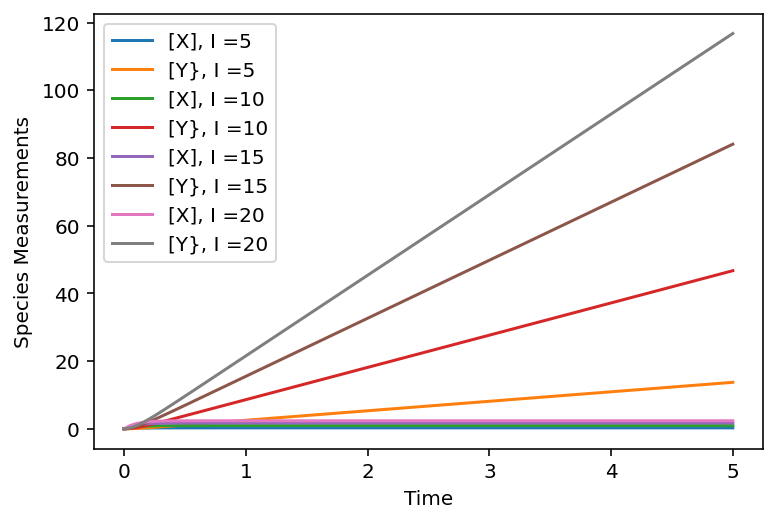

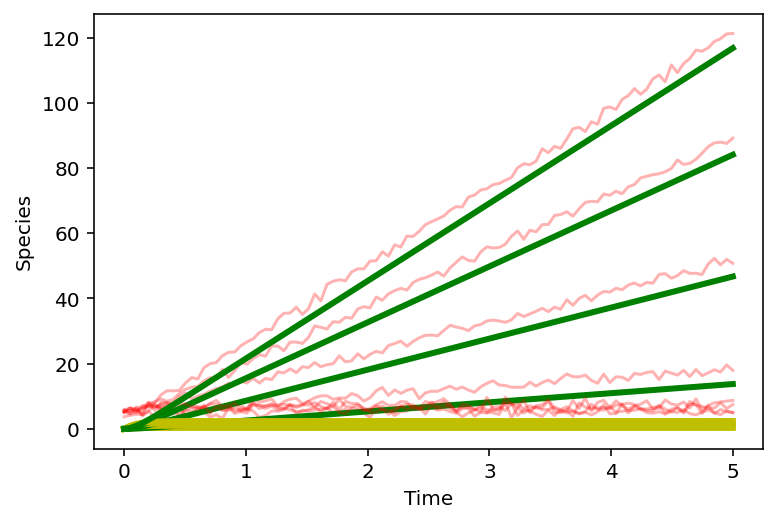

In [30]:
num_trajectories = 4 # each with different initial condition
initial_condition_list = [{'I':5},{'I':10},{'I':15},{'I':20}] 
timepoints = np.linspace(0,5,100)
result_list = []
for init_cond in initial_condition_list:
    M.set_species(init_cond)
    result = py_simulate_model(timepoints, Model = M)
    result_list.append(result)
    plt.plot(timepoints, result['X'], label = '[X], I =' + str(list(init_cond.values())[0]))
    plt.plot(timepoints, result['Y'], label = '[Y}, I =' + str(list(init_cond.values())[0]))
plt.xlabel('Time')
plt.ylabel('Species Measurements')
plt.legend()
plt.show()

exp_data = pd.DataFrame()
exp_data['timepoints'] = timepoints
for i in range(num_trajectories):
    exp_data['X' + str(i)] = result_list[i]['X'] + np.random.normal(5, 1, size = np.shape(result['X']))
    exp_data['Y' + str(i)] = result_list[i]['Y'] + np.random.normal(5, 1, size = np.shape(result['Y']))
    plt.plot(timepoints, exp_data['X' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, exp_data['Y' + str(i)], 'r', alpha = 0.3)
    plt.plot(timepoints, result_list[i]['X'], 'y', linewidth = 3)
    plt.plot(timepoints, result_list[i]['Y'], 'g', linewidth = 3)
plt.xlabel('Time')
plt.ylabel('Species')
plt.show()
exp_data.to_csv('data/multiple_measurements.csv')


Here's how the CSV file looks:

In [31]:
exp_data

timepoints        X0         Y0        X1         Y1        X2         Y2  \
0     0.000000  4.985548   3.705775  5.288346   5.936790  5.199106   5.754041   
1     0.050505  4.783702   4.153773  5.295139   4.536174  6.495252   6.360828   
2     0.101010  6.442737   4.474305  5.656959   5.299661  5.559310   4.869733   
3     0.151515  4.000520   4.327192  6.142117   5.174347  6.451367   7.186762   
4     0.202020  5.595321   5.363856  6.828501   7.922837  7.301370   6.758412   
..         ...       ...        ...       ...        ...       ...        ...   
95    4.797980  5.746537  17.146819  7.132461  50.552631  6.269632  86.542498   
96    4.848485  4.946942  18.132195  4.758855  52.301772  6.369271  87.705485   
97    4.898990  4.359375  17.406402  5.895698  50.312041  8.003066  87.958510   
98    4.949495  5.398518  19.611091  5.336371  51.984863  6.240352  87.544389   
99    5.000000  4.966889  17.922821  5.007636  50.768080  7.452661  89.186395   

          X3          Y3  
0   5.096561    5.494094  
1   6.270177    5.574333  
2   5.951189    6.610186  
3   4.351575    6.647760  
4   7.875462    8.144996  
..       ...         ...  
95  7.139975  116.866592  
96  7.979925  118.810728  
97  8.229467  119.659059  
98  8.520971  121.153451  
99  8.701941  121.264389  

[100 rows x 9 columns]

Now, we load this CSV file in the appropriate format (a list of dataframes where each dataframe corresponds to an initial condition and each dataframe consists of both measurements $X$ and $Y$)

In [32]:
exp_data = []
for i in range(num_trajectories):
    df = pd.read_csv('data/multiple_measurements.csv', usecols = ['timepoints', 'X'+str(i),'Y'+str(i)])
    df.columns = ['timepoints', 'X', 'Y']
    exp_data.append(df)

creating an ensemble sampler with threads= 1


100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:43<00:00, 91.39it/s]


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


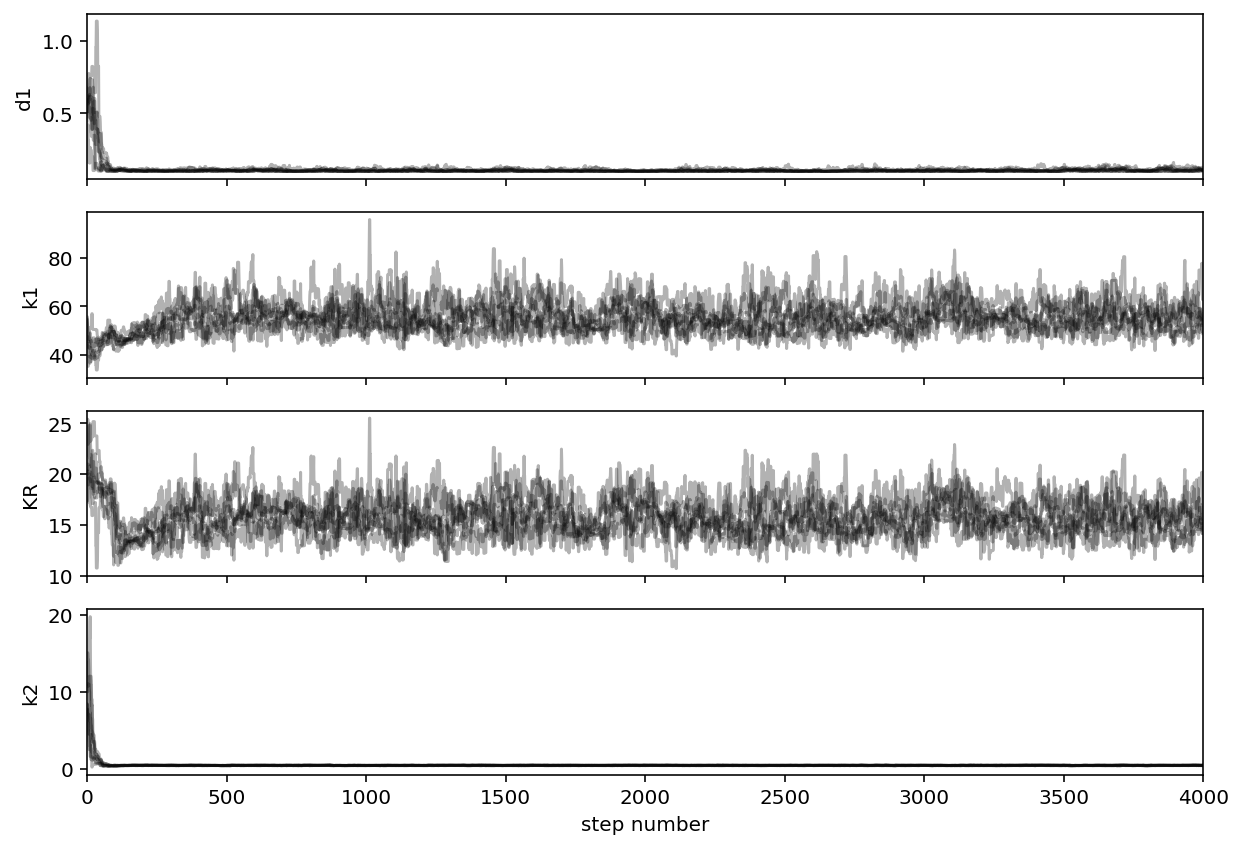

In [33]:
from bioscrape.inference import py_inference
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100], 'k2':['uniform', 0, 100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X','Y'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 8, init_seed = 0.15, nsteps = 4000, sim_type = 'deterministic',
                            params_to_estimate = ['d1','k1','KR', 'k2'], prior = prior, convergence_check = False)


Finally, bioscrape inference also allows stochastic simulations! So, you can run a stochastic inference by simply changing the `sim_type` argument to `stochastic` instead of `deterministic`. 

# Stochastic Inference 

creating an ensemble sampler with threads= 1


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Ayush\anaconda3\lib\site-packages\emcee-3.1.2-py3.9.egg\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.29it/s]
C:\Users\Ayush\anaconda3\lib\site-packages\bioscrape-1.0.4-py3.9-win-amd64.egg\bioscrape\inference_setup.py:540: UserWarning: corner package not found - cannot plot parameter distributions.
  warnings.warn('corner package not found - cannot plot parameter distributions.')


Results written tomcmc_results.csv and mcmc_results.txt
Successfully completed MCMC parameter identification procedure.Check the MCMC diagnostics to evaluate convergence.
Parameter posterior distribution convergence plots:


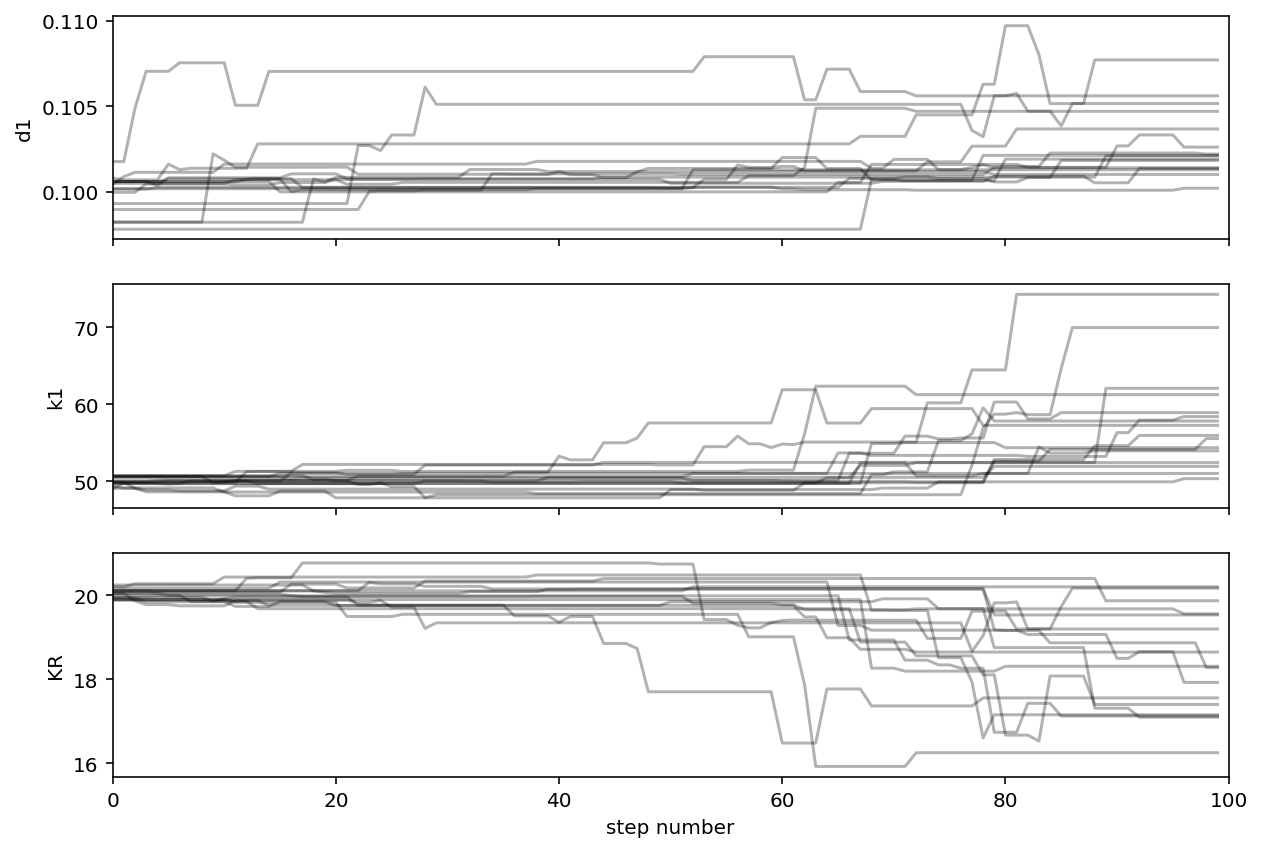

In [34]:
from bioscrape.inference import py_inference
prior = {'d1' : ['uniform', 0.1, 10], 'k1' : ['uniform',0,100], 'KR' : ['uniform',0,100]}

sampler, pid = py_inference(Model = M, exp_data = exp_data, measurements = ['X', 'Y'], time_column = ['timepoints'],
                            initial_conditions = initial_condition_list,
                            nwalkers = 16, init_seed = np.array([0.1,50,20]), nsteps = 100, discard = 10,
                            sim_type = 'stochastic',
                            params_to_estimate = ['d1','k1','KR'], prior = prior, debug=False)


That is not all though! Bioscrape Inference can do more:

## Maximum-Likelihood estimates (such as least-squares): Bioscrape Inference is compatible with the Python LMFit package. Check out the notebook: `OD data using least squares(LMFit example).ipynb`.

1. All examples above are available as individual notebooks at the following location: `bioscrape/inference examples/individual examples/`

Check out our Github page for more information: https://github.com/biocircuits/bioscrape/
